<a href="https://colab.research.google.com/github/Harumaru58/ASD_Autora_notebooks/blob/main/Brown_Submission_Modeling_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Drift Diffusion model of Task-Switching and Interference

In this Python notebook we investigate the effects of switching tasks and thus of interference on parameters of a drift-diffusion model (DDM) - namley the drift rate and boundary separation. Further, we also look into the effects of stimulus congruency and given time (here, in terms of maximum trial duration) on decision-making.

We first implement and simulate data from the following five models:

* Model 1: Simple DDM without any regression
* Model 2: DDM with regression for categorical parameters of task_switch and congruency on drift rate ("v")
* Model 3: Same as model 2, but on boundary separation ("a") instead
* Model 4: DDM with regression for categorical parameter of trial duration on boundary separation ("a") as well as of task_switch and congruency on drift rate ("v")
* Model 5: same as model 4, but with categorical parameter of trial duration on drift rate ("v"), and task_switch and congruency on boundary separation ("a") instead

We then fit these models to the simulated data in order to see if we can recover the original parameters well. Finally, we fit the models to real behavioral data and compare them to see which one performs, and therefore explains human decision-making, the best.



In [ ]:
!pip install hssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.9/764.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.2/348.2 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.1

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hssm
import arviz as az
import gdown

##Plot function


We will plot response time distributions for the simulated and real data, so let's put the function here.

In [ ]:
def plot_rt(df):
  plt.hist(df['rt'] * df['response'],
          histtype='step', bins = 40, density=True)
  plt.xlabel('rt')
  plt.ylabel('density')
  plt.xlim(-8, 8)

# Data simulation

We first simulate data using the 3 conditions - fixed parameters, regression on a and regression on v.

In [ ]:
# Set up common parameters
n_trials = 230
n_participants = 43

task_switch = np.random.choice(2, size=n_trials*n_participants)
congruency = np.random.choice(2, size=n_trials*n_participants)

trial_durations = [1.845, 2.200, 2.300, 2.600, 2.800, 2.900, 2.970, 3.000]
trial_duration_per_participant = np.random.choice(trial_durations, size=n_participants)
trial_duration = np.repeat(trial_duration_per_participant, n_trials)

## Model 1: simple DDM
Model 1: Simple DDM without any regression.

  Description: Incorporates the effects of task switching and congruency on the drift rate.


    Parameters:
        Drift rate (v)
        Boundary separation (a)
        Non-decision time (t)
        Starting point (z)

  Purpose: Serves as a baseline model to understand the basic decision-making process without additional complexities.

In [ ]:
# Simulate simple DDM with fixed parameters
true_params_simple = dict(a = 1.0,
                          z = 0.4,
                          t = 0.1,
                          v = 1.2)

# base dataset
sim_dataset_simple = hssm.simulate_data(model = 'ddm',
                                        theta = true_params_simple,
                                        size = n_trials*n_participants)

# Adding covariates into the datsaframe
sim_dataset_simple['task_switch'] = task_switch
sim_dataset_simple['congruency'] = congruency
sim_dataset_simple

rt  response  task_switch  congruency
0    0.951457       1.0            0           1
1    1.038029       1.0            0           0
2    1.343248       1.0            1           1
3    1.288928       1.0            1           0
4    2.653638       1.0            0           0
..        ...       ...          ...         ...
995  0.742768       1.0            0           1
996  0.732539       1.0            1           0
997  1.701494       1.0            1           1
998  1.002263       1.0            1           1
999  2.453700      -1.0            0           0

[1000 rows x 4 columns]

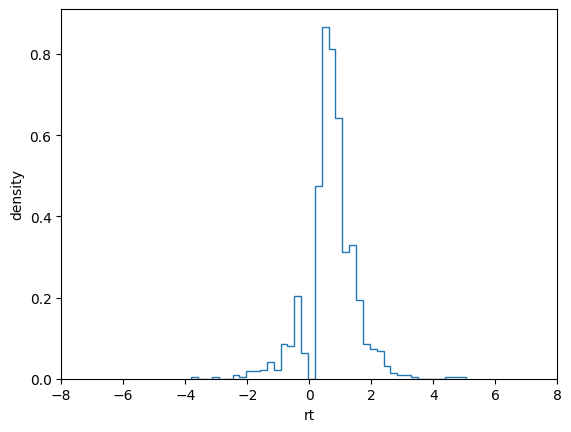

In [ ]:
plot_rt(sim_dataset_simple)

## Model 2: model with regression on drift rate (v)
DDM with regression for categorical parameters of task_switch and congruency on drift rate (v)

Description: Incorporates the effects of task switching and congruency on the drift rate.
Parameters:

    Drift rate (v) influenced by task_switch and congruency
    Boundary separation (a)
    Non-decision time (t)
    Starting point (z)

Purpose: Examines how task-switching and congruency impact the speed of evidence accumulation.

In [ ]:
# Simulate with regression on v
v_intercept = 1.2
v_task_switch = -0.8
v_congruency = 0.5
v_reg_v = v_intercept + (v_task_switch * task_switch) + (v_congruency * congruency)

true_params_reg_v = dict(a = 1.0,
                          z = 0.4,
                          t = 0.1,
                          v = v_reg_v,
                          v_task_switch = v_task_switch,
                          v_congruency = v_congruency,
                          v_Intercept = v_intercept)

# base dataset
sim_dataset_reg_v = hssm.simulate_data(model = 'ddm',
                                theta = true_params_reg_v,
                                size = 1)

# Adding covariates into the datsaframe
sim_dataset_reg_v['task_switch'] = task_switch
sim_dataset_reg_v['congruency'] = congruency
sim_dataset_reg_v

rt  response  task_switch  congruency
0    0.791770       1.0            0           1
1    2.519818       1.0            0           0
2    0.554492       1.0            1           1
3    0.482800       1.0            1           0
4    1.622707      -1.0            0           0
..        ...       ...          ...         ...
995  0.918862       1.0            0           1
996  1.545899       1.0            1           0
997  0.487495       1.0            1           1
998  0.261282       1.0            1           1
999  0.841959       1.0            0           0

[1000 rows x 4 columns]

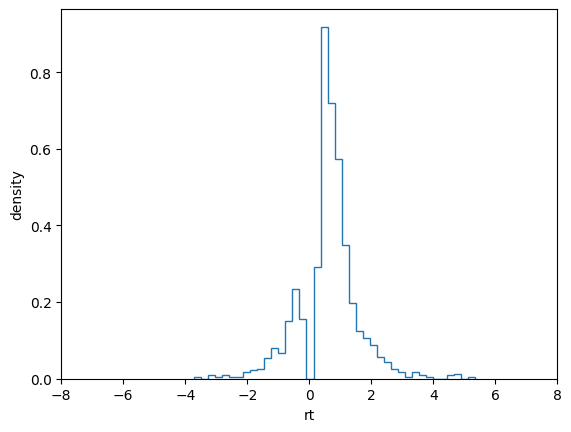

In [ ]:
plot_rt(sim_dataset_reg_v)

## Model 3: model with regression on boundary separation (a)

Description: Incorporates the effects of task switching and congruency on the boundary separation.
Parameters:

    Drift rate (v)
    Boundary separation (a) influenced by task_switch and congruency
    Non-decision time (t)
    Starting point (z)

Purpose: Investigates how task-switching and congruency influence decision thresholds.

In [ ]:
# Simulate with regression on a
a_intercept = 1.0
a_task_switch = 0.8
a_congruency = -0.5
a_reg_v = a_intercept + (a_task_switch * task_switch) + (a_congruency * congruency)

true_params_reg_a = dict(v = 1.2,
                          z = 0.4,
                          t = 0.1,
                          a = a_reg_v,
                          a_task_switch = a_task_switch,
                          a_congruency = a_congruency,
                          a_Intercept = a_intercept)

# base dataset
sim_dataset_reg_a = hssm.simulate_data(model = 'ddm',
                                theta = true_params_reg_a,
                                size = 1)

# Adding covariates into the dataframe
sim_dataset_reg_a['task_switch'] = task_switch
sim_dataset_reg_a['congruency'] = congruency
sim_dataset_reg_a

rt  response  task_switch  congruency
0    0.380855       1.0            0           1
1    0.695401      -1.0            0           0
2    1.010354       1.0            1           1
3    2.564797       1.0            1           0
4    0.274974       1.0            0           0
..        ...       ...          ...         ...
995  0.518734       1.0            0           1
996  2.185264       1.0            1           0
997  1.526698       1.0            1           1
998  1.688513       1.0            1           1
999  0.544291       1.0            0           0

[1000 rows x 4 columns]

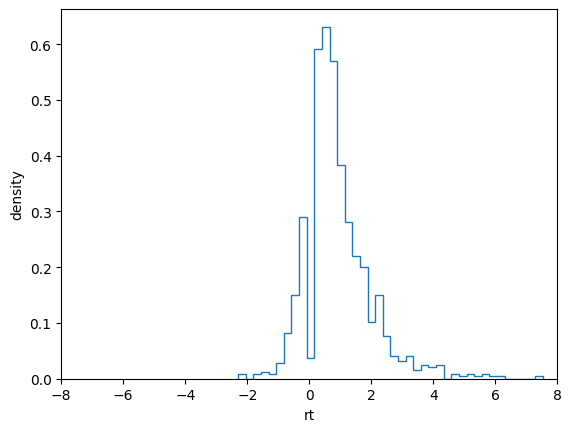

In [ ]:
plot_rt(sim_dataset_reg_a)

## Model 4: model with regression on drift rate v (task_switch and congruency) and boundary separation a (trial_duration)

Description: Includes the effects of trial duration on boundary separation and task-switching and congruency on drift rate.
Parameters:

    Drift rate (v) influenced by task_switch and congruency
    Boundary separation (a) influenced by trial duration
    Non-decision time (t)
    Starting point (z)

Purpose: Explores the combined effects of trial duration, task-switching, and congruency on decision-making.

In [ ]:
# Simulate with regression on v (task_switch and congruency) and a (trial_duration)
v_intercept_vCTS_aTD = 1.2
v_task_switch_vCTS_aTD = -0.8
v_congruency_vCTS_aTD = 0.5
v_reg_vCTS_aTD = v_intercept_vCTS_aTD + (v_task_switch_vCTS_aTD * task_switch) + (v_congruency_vCTS_aTD * congruency)

a_intercept_vCTS_aTD = 1.0
a_trial_duration_vCTS_aTD = 0.1
a_reg_vCTS_aTD = a_intercept_vCTS_aTD + (a_trial_duration_vCTS_aTD * trial_duration)

true_params_reg_vCTS_aTD = dict(z = 0.4,
                                t = 0.1,
                                v = v_reg_vCTS_aTD,
                                v_task_switch = v_task_switch_vCTS_aTD,
                                v_congruency = v_congruency_vCTS_aTD,
                                v_Intercept = v_intercept_vCTS_aTD,
                                a = a_reg_vCTS_aTD,
                                a_trial_duration= a_trial_duration_vCTS_aTD,
                                a_Intercept= a_intercept_vCTS_aTD)

# base dataset
sim_dataset_reg_vCTS_aTD = hssm.simulate_data(model = 'ddm',
                                              theta = true_params_reg_vCTS_aTD,
                                              size = 1)

# Adding covariates into the datsaframe
sim_dataset_reg_vCTS_aTD['task_switch'] = task_switch
sim_dataset_reg_vCTS_aTD['congruency'] = congruency
sim_dataset_reg_vCTS_aTD['trial_duration'] = trial_duration
sim_dataset_reg_vCTS_aTD

rt  response  task_switch  congruency  trial_duration
0     5.117137      -1.0            1           0            2.97
1     0.582898       1.0            1           1            2.97
2     1.295304       1.0            1           0            2.97
3     0.683010       1.0            0           0            2.97
4     1.531327       1.0            0           0            2.97
...        ...       ...          ...         ...             ...
9885  1.412729       1.0            0           0            2.80
9886  0.431922      -1.0            1           0            2.80
9887  0.456041       1.0            0           1            2.80
9888  0.686267       1.0            0           0            2.80
9889  0.845972       1.0            0           1            2.80

[9890 rows x 5 columns]

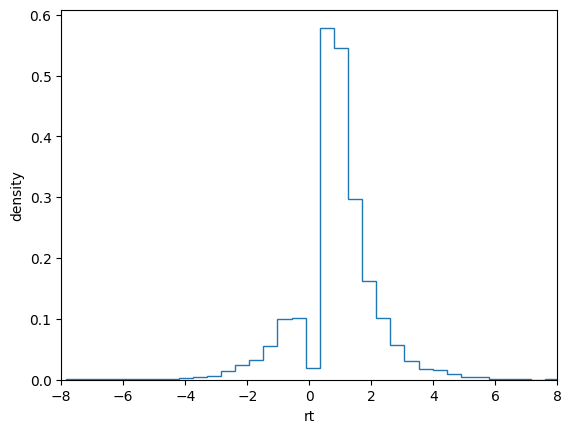

In [ ]:
plot_rt(sim_dataset_reg_vCTS_aTD)

## Model 5: model with regression on drift rate v (trial_duration) and boundary separation a (task_switch and congruency)

Description: Swaps the influence of trial duration to drift rate and task-switching and congruency to boundary separation.
Parameters:

    Drift rate (v) influenced by trial duration
    Boundary separation (a) influenced by task_switch and congruency
    Non-decision time (t)
    Starting point (z)

Purpose: Examines the different impacts of trial duration, task-switching, and congruency on different aspects of decision-making.

In [ ]:
# Simulate with regression on a (task_switch and congruency) and v (trial_duration)
a_intercept = 1.0
v_intercept = 1.2
a_task_switch = 0.8
a_congruency = -0.5
a_trial_duration = 0.1
a_reg_v = a_intercept + (a_task_switch * task_switch) + (a_congruency * congruency)
v_reg_trial = v_intercept + (a_trial_duration * trial_duration)

true_params_reg_aCTS_vTD = dict(
                          z = 0.4,
                          t = 0.1,
                          v = v_reg_trial,
                          v_Intercept = v_intercept,
                          a_trial_duration = a_trial_duration,
                          a = a_reg_v,
                          a_task_switch = a_task_switch,
                          a_congruency = a_congruency,
                          a_Intercept = a_intercept)

# base dataset
sim_dataset_reg_aCTS_vTD = hssm.simulate_data(model = 'ddm',
                                theta = true_params_reg_aCTS_vTD,
                                size = 1)

# Adding covariates into the datsaframe
sim_dataset_reg_aCTS_vTD['task_switch'] = task_switch
sim_dataset_reg_aCTS_vTD['congruency'] = congruency
sim_dataset_reg_aCTS_vTD['trial_duration'] = trial_duration
sim_dataset_reg_aCTS_vTD

rt  response  task_switch  congruency  trial_duration
0     1.848800       1.0            1           0            2.97
1     3.216988       1.0            1           0            2.97
2     1.933434       1.0            1           0            2.97
3     0.247630       1.0            0           1            2.97
4     0.946354       1.0            1           0            2.97
...        ...       ...          ...         ...             ...
9885  0.304650       1.0            0           1            2.80
9886  0.654293       1.0            1           1            2.80
9887  0.600303       1.0            0           0            2.80
9888  0.247978      -1.0            0           0            2.80
9889  0.204718       1.0            0           1            2.80

[9890 rows x 5 columns]

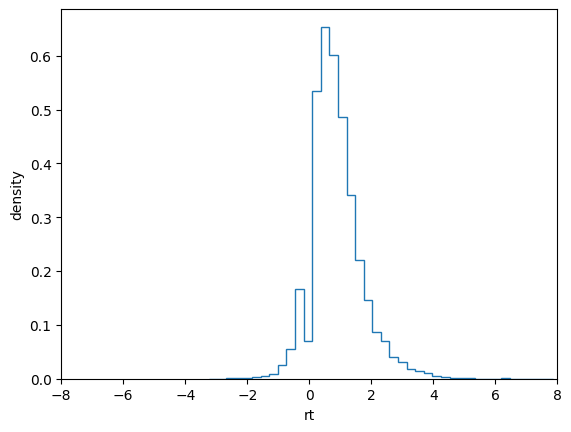

In [ ]:
plot_rt(sim_dataset_reg_aCTS_vTD)

# Model Implementations and Simulations

Here we define our five models.


## Model 1: simple DDM


In [ ]:
simple_ddm = hssm.HSSM(data=sim_dataset_simple)
simple_ddm

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

## Model 2: model with regression on drift rate (v)


In [ ]:
regression_v = hssm.HSSM(
    data=sim_dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 2.0
                }
            },
            "formula": "v ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        }
    ]
)
regression_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + C(congruency) + C(task_switch)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.0)
        v_C(congruency) ~ Normal(mu: 0.0, sigma: 0.25)
        v_C(task_switch) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

## Model 3: model with regression on boundary separation (a)


In [ ]:
regression_a = hssm.HSSM(
    data=sim_dataset_reg_a,
    include=[
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "a ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        }
    ]
)
regression_a

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + C(congruency) + C(task_switch)
    Priors:
        a_Intercept ~ HalfNormal(sigma: 2.0)
        a_C(congruency) ~ Normal(mu: 0.0, sigma: 0.25)
        a_C(task_switch) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

## Model 4: model with regression on drift rate v (task_switch and congruency) and boundary separation a (trial_duration)

In [ ]:
regression_vCTS_aTD = hssm.HSSM(
    data=sim_dataset_reg_vCTS_aTD,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 2.0
                }
            },
            "formula": "v ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "a ~ 1 + C(trial_duration)",
            "link": "identity",
        }
    ]
)
regression_vCTS_aTD

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 9890

Parameters:

v:
    Formula: v ~ 1 + C(congruency) + C(task_switch)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.0)
        v_C(congruency) ~ Normal(mu: 0.0, sigma: 0.25)
        v_C(task_switch) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + C(trial_duration)
    Priors:
        a_Intercept ~ HalfNormal(sigma: 2.0)
        a_C(trial_duration) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

## Model 5: model with regression on drift rate v (trial_duration) and boundary separation a (task_switch and congruency)

In [ ]:
reg_aCTS_vTD = hssm.HSSM(
    data=sim_dataset_reg_aCTS_vTD,
    include=[
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "a ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        },
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 2.0
                }
            },
            "formula": "v ~ 1 + C(trial_duration)",
            "link": "identity",
        }
    ]
)
reg_aCTS_vTD

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 9890

Parameters:

v:
    Formula: v ~ 1 + C(trial_duration)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.0)
        v_C(trial_duration) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + C(congruency) + C(task_switch)
    Priors:
        a_Intercept ~ HalfNormal(sigma: 2.0)
        a_C(congruency) ~ Normal(mu: 0.0, sigma: 0.25)
        a_C(task_switch) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

# Parameter Fitting

Let's see how our different models' parameters fit to the simulated data.



###Model 1

In [ ]:
simple_ddm_sample = simple_ddm.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=1000,
    tune=500,
    idata_kwargs=dict(log_likelihood=False)
)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1500/1500 [00:10<00:00, 147.15it/s, 7 steps of size 4.17e-01. acc. prob=0.93] 


### Model 2

In [ ]:
regression_v_sample = regression_v.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=1000,
    tune=500,
    idata_kwargs=dict(log_likelihood=False)
)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1500/1500 [00:09<00:00, 151.58it/s, 7 steps of size 5.15e-01. acc. prob=0.91]


### Model 3

In [ ]:
regression_a_sample = regression_a.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=1000,
    tune=500,
    idata_kwargs=dict(log_likelihood=False)
)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1500/1500 [00:14<00:00, 106.94it/s, 15 steps of size 3.69e-01. acc. prob=0.92]


## Model 4

In [ ]:
regression_vCTS_aTD_sample = regression_vCTS_aTD.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=1000,
    tune=500,
    idata_kwargs=dict(log_likelihood=False)
)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

(this model also ran properly in another notebook, only the outputs could not have been pasted in this case)

## Model 5

In [ ]:
reg_aCTS_vTD_sample = reg_aCTS_vTD.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=1000,
    tune=500,
    idata_kwargs=dict(log_likelihood=False)
)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1500/1500 [00:41<00:00, 35.75it/s, 15 steps of size 2.65e-01. acc. prob=0.94]


# Parameter Recovery

*  We defined realistic ranges for each parameter (v, a, t, z) based on prior knowledge or exploratory data analysis.

* Simulation: Using the defined parameter ranges to generate synthetic datasets for each model.

*   We used the functions above to generate behavior from models, for a given set of (randomly sampled) parameters.

* Fitting: Fit each model to its respective synthetic dataset to recover the parameters.

* Quantitative Evaluation: Compare recovered parameters with the true values used in the simulations, typically using correlation plots or scatter plots.

* Plotting Parameter Recovery:

    Correlation Plots: Plot true parameters on the x-axis and recovered parameters on the y-axis to visualize the accuracy of parameter recovery.
    Scatter Plots: Overlay points representing true vs. recovered parameters to see how closely they align.






## Model 1: simple DDM

In [ ]:
az.summary(simple_ddm_sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  1.026  0.022   0.985    1.067      0.001    0.000    1922.0    2174.0   
t  0.100  0.010   0.080    0.119      0.000    0.000    1858.0    2222.0   
v  1.289  0.057   1.176    1.392      0.001    0.001    2183.0    2215.0   
z  0.398  0.013   0.372    0.420      0.000    0.000    2037.0    2194.0   

   r_hat  
a    1.0  
t    1.0  
v    1.0  
z    1.0

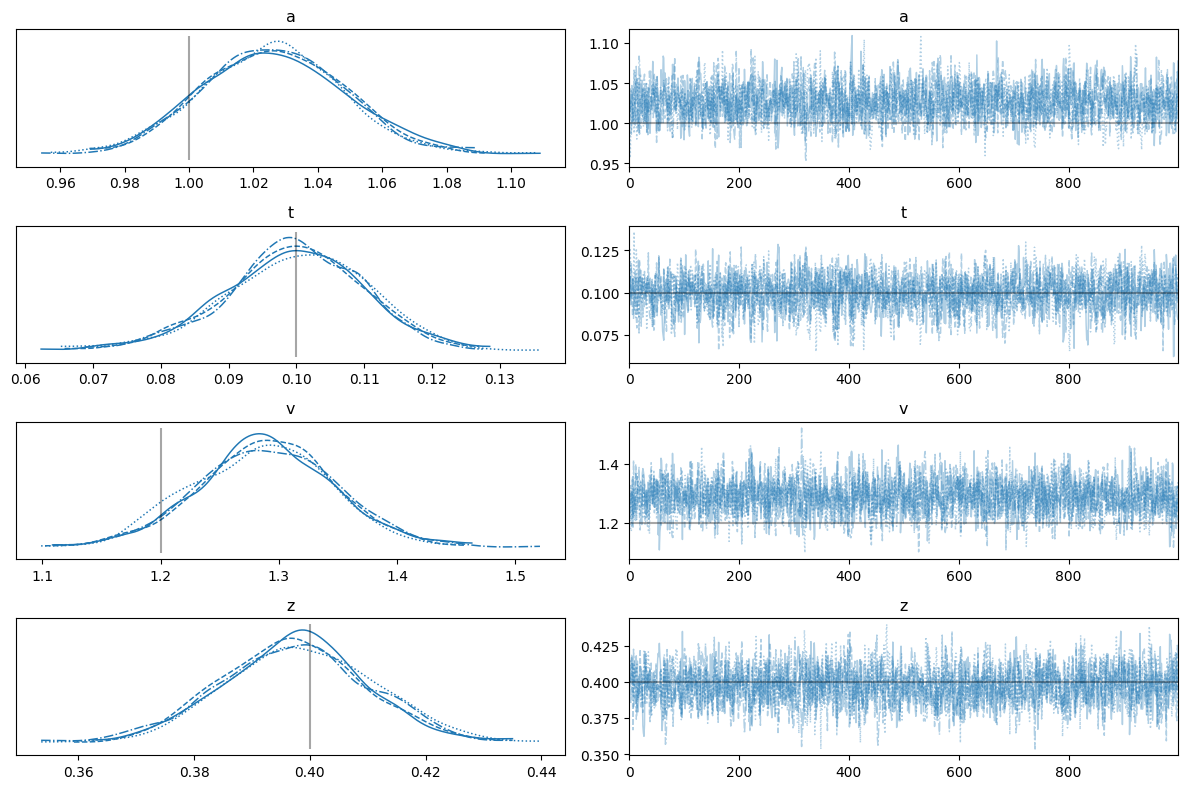

In [ ]:
az.plot_trace(simple_ddm_sample, lines=[(key_, {}, true_params_simple[key_]) for key_ in true_params_simple])
plt.tight_layout()

## Model 2: model with regression on drift rate (v)

In [ ]:
az.summary(regression_v_sample, var_names=["~v"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                    0.997  0.019   0.960    1.033      0.000    0.000   
t                    0.104  0.009   0.088    0.120      0.000    0.000   
v_C(congruency)[1]   0.477  0.074   0.335    0.616      0.001    0.001   
v_C(task_switch)[1] -0.783  0.074  -0.916   -0.638      0.001    0.001   
v_Intercept          1.339  0.078   1.195    1.485      0.001    0.001   
z                    0.384  0.011   0.364    0.405      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
a                      2784.0    2563.0    1.0  
t                      2871.0    2397.0    1.0  
v_C(congruency)[1]     5088.0    2770.0    1.0  
v_C(task_switch)[1]    3908.0    2917.0    1.0  
v_Intercept            3685.0    2750.0    1.0  
z                      3899.0    3081.0    1.0

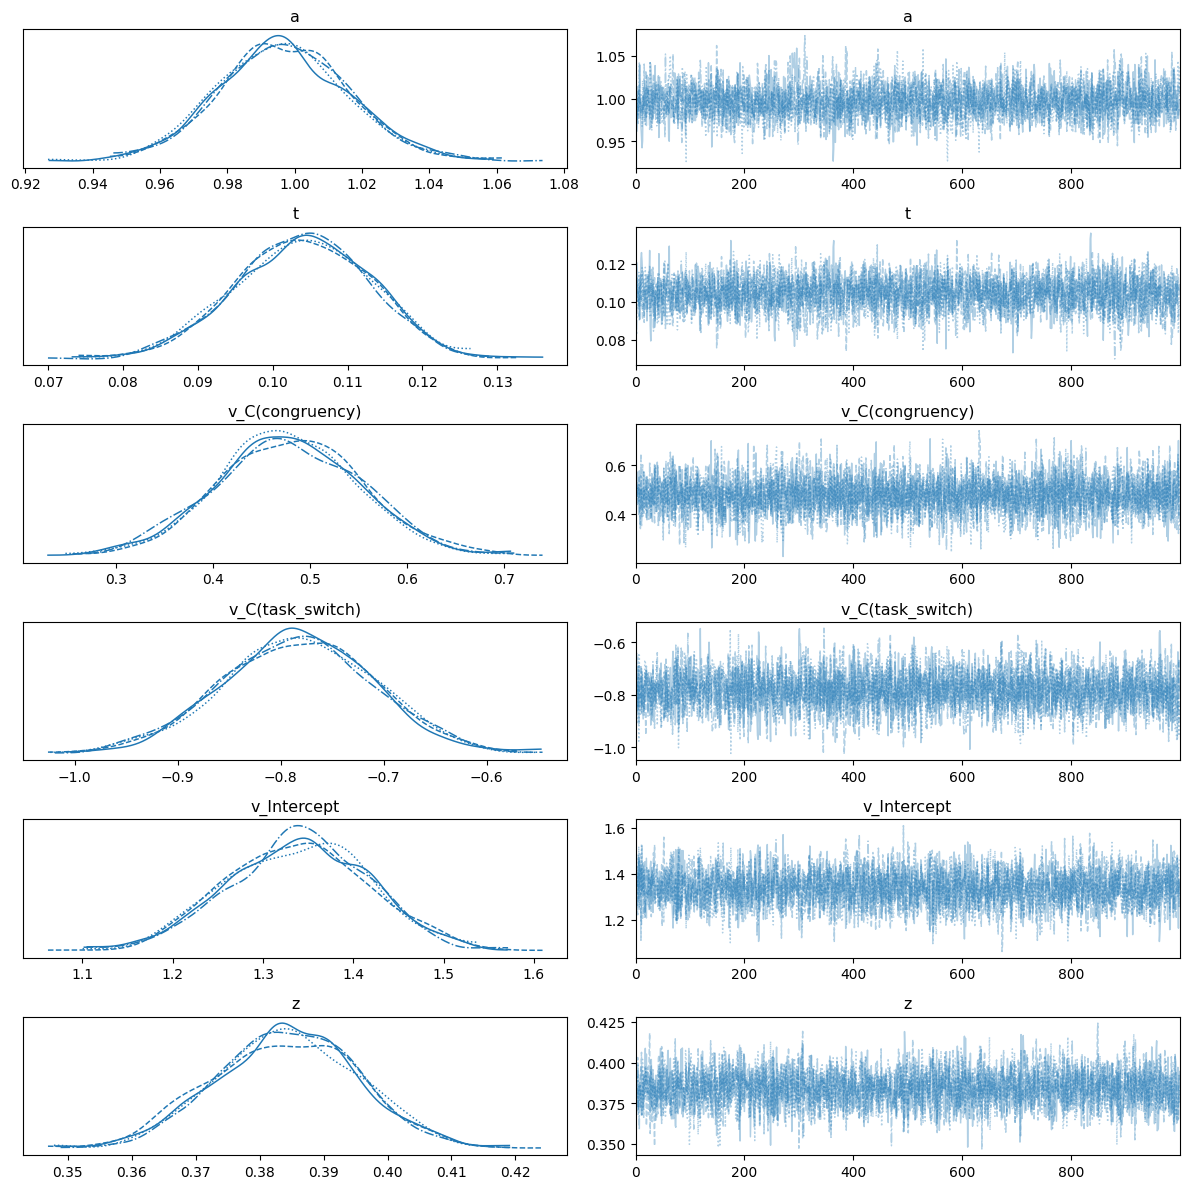

In [ ]:
az.plot_trace(regression_v_sample, var_names=["~v"])
plt.tight_layout()

## Model 3: with Regression on Boundary Separation

In [ ]:
az.summary(regression_a_sample, var_names=["~a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_C(congruency)[1]  -0.459  0.027  -0.509   -0.410      0.000    0.000   
a_C(task_switch)[1]  0.799  0.035   0.735    0.864      0.001    0.000   
a_Intercept          0.977  0.026   0.930    1.027      0.000    0.000   
t                    0.097  0.004   0.090    0.104      0.000    0.000   
v                    1.279  0.052   1.183    1.378      0.001    0.001   
z                    0.392  0.012   0.371    0.415      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
a_C(congruency)[1]     3229.0    2965.0    1.0  
a_C(task_switch)[1]    2433.0    2460.0    1.0  
a_Intercept            3343.0    3021.0    1.0  
t                      3306.0    2396.0    1.0  
v                      2684.0    2267.0    1.0  
z                      2991.0    2708.0    1.0

array([[<Axes: title={'center': 'a_C(congruency)'}>,
        <Axes: title={'center': 'a_C(congruency)'}>],
       [<Axes: title={'center': 'a_C(task_switch)'}>,
        <Axes: title={'center': 'a_C(task_switch)'}>],
       [<Axes: title={'center': 'a_Intercept'}>,
        <Axes: title={'center': 'a_Intercept'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

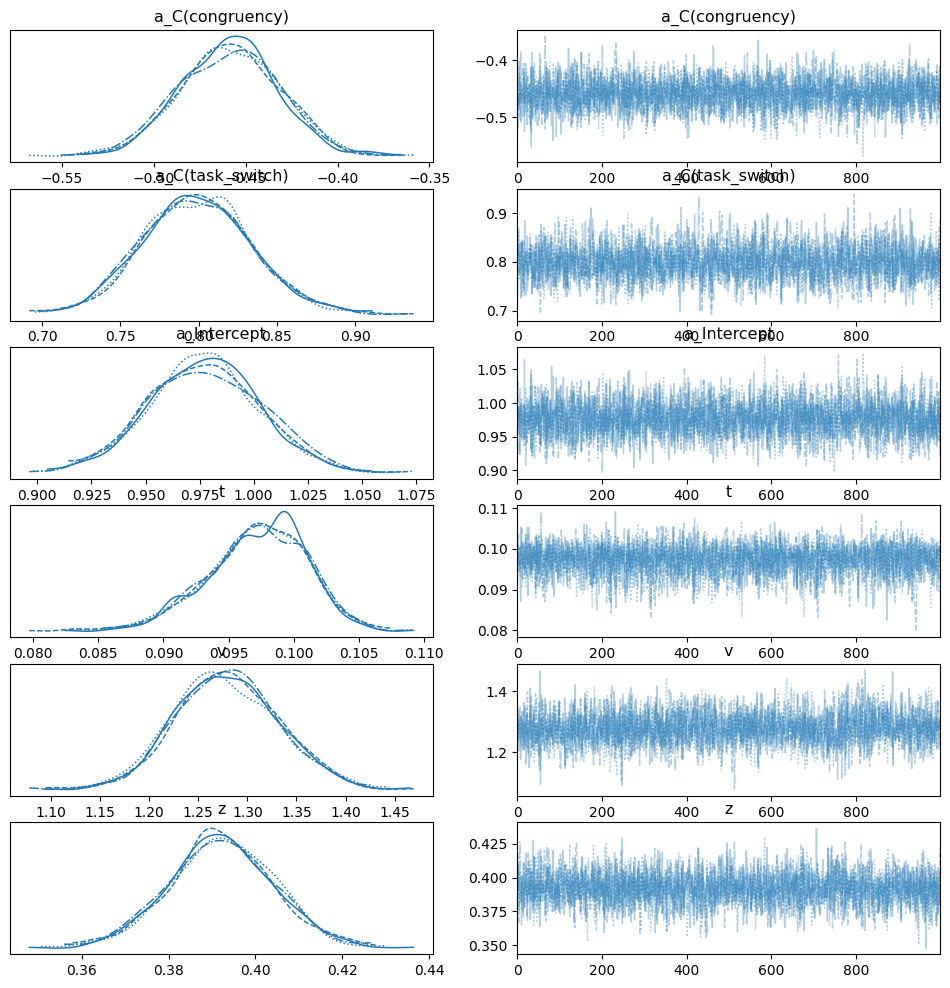

In [ ]:
az.plot_trace(regression_a_sample, var_names=["~a"])

## Model 4: model with regression on drift rate v (task_switch and congruency) and boundary separation a (trial_duration)

In [ ]:
az.summary(regression_vCTS_aTD_sample, var_names=["~a", "~v"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_C(trial_duration)[2.2]   0.004  0.026  -0.042    0.056        0.0      0.0   
a_C(trial_duration)[2.3]   0.050  0.020   0.013    0.086        0.0      0.0   
a_C(trial_duration)[2.6]   0.059  0.017   0.027    0.092        0.0      0.0   
a_C(trial_duration)[2.8]   0.095  0.016   0.065    0.124        0.0      0.0   
a_C(trial_duration)[2.9]   0.108  0.024   0.062    0.152        0.0      0.0   
a_C(trial_duration)[2.97]  0.112  0.024   0.066    0.156        0.0      0.0   
a_C(trial_duration)[3.0]   0.099  0.021   0.061    0.139        0.0      0.0   
a_Intercept                1.175  0.013   1.150    1.200        0.0      0.0   
t                          0.118  0.004   0.110    0.126        0.0      0.0   
v_C(congruency)[1]         0.499  0.021   0.460    0.539        0.0      0.0   
v_C(task_switch)[1]       -0.819  0.021  -0.859   -0.780        0.0      0.0   
v_Intercept                1.266  0.021   1.225    1.306        0.0      0.0   
z                          0.400  0.004   0.393    0.407        0.0      0.0   

                           ess_bulk  ess_tail  r_hat  
a_C(trial_duration)[2.2]     3362.0    3024.0    1.0  
a_C(trial_duration)[2.3]     2615.0    2953.0    1.0  
a_C(trial_duration)[2.6]     2600.0    2958.0    1.0  
a_C(trial_duration)[2.8]     2213.0    2654.0    1.0  
a_C(trial_duration)[2.9]     3034.0    2989.0    1.0  
a_C(trial_duration)[2.97]    3120.0    2736.0    1.0  
a_C(trial_duration)[3.0]     2767.0    2958.0    1.0  
a_Intercept                  2000.0    2146.0    1.0  
t                            3001.0    2412.0    1.0  
v_C(congruency)[1]           4179.0    2549.0    1.0  
v_C(task_switch)[1]          3338.0    3063.0    1.0  
v_Intercept                  3265.0    3194.0    1.0  
z                            2866.0    3088.0    1.0

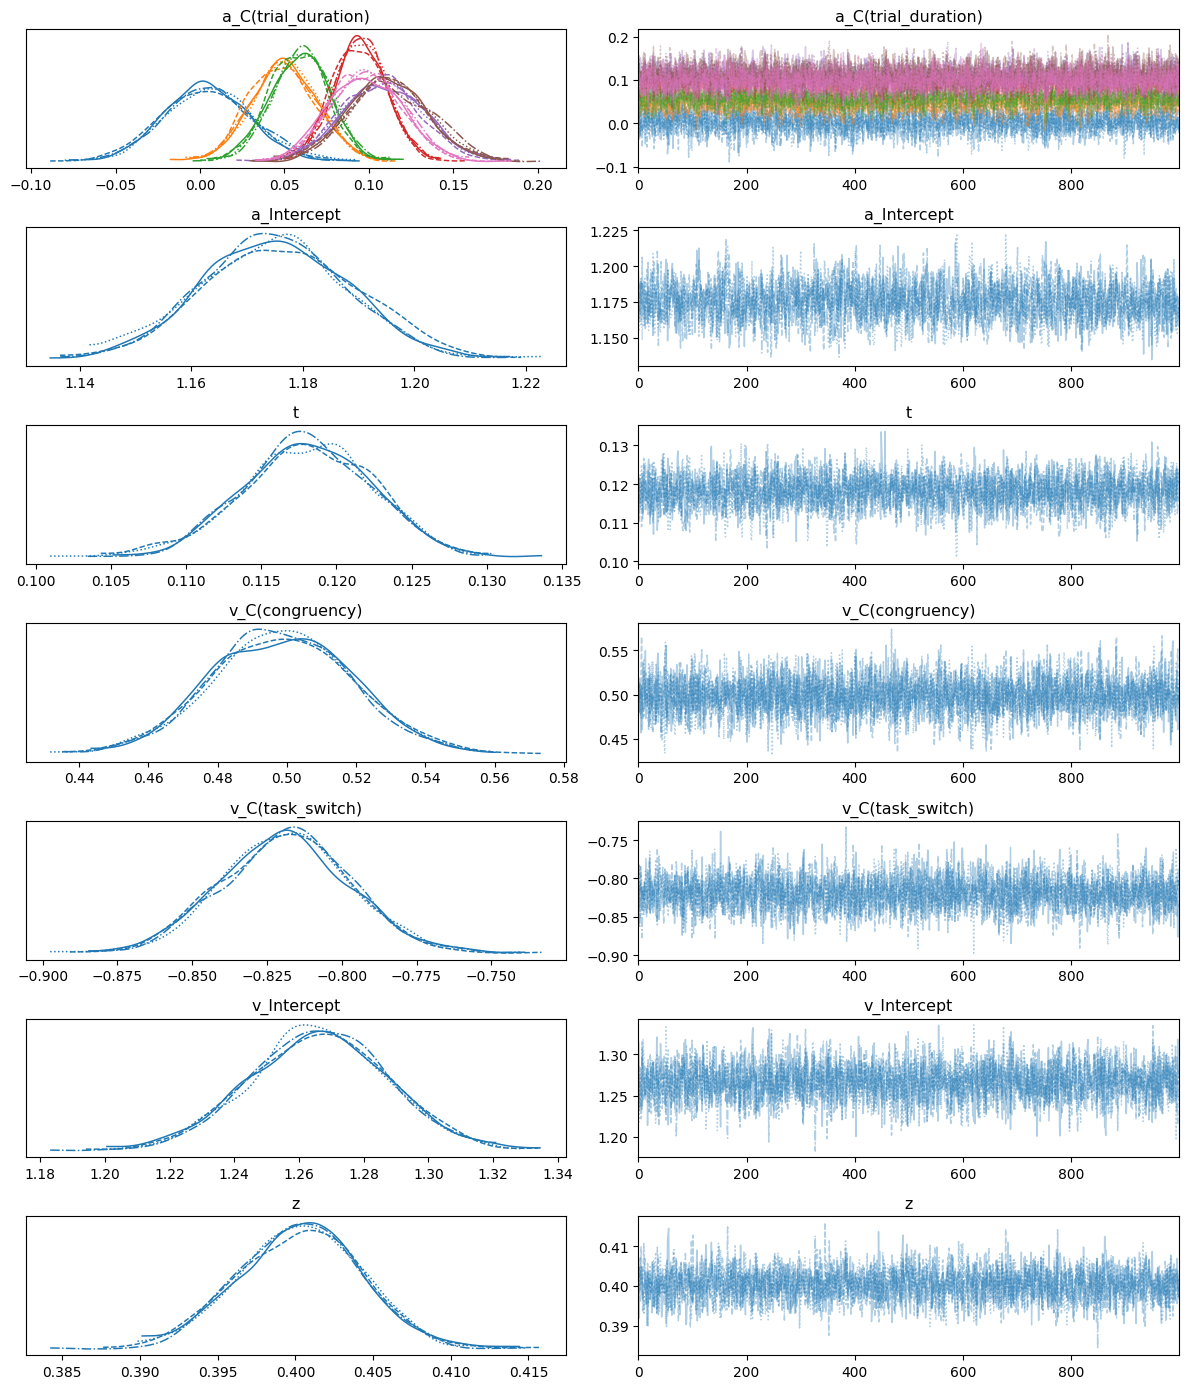

In [ ]:
az.plot_trace(regression_vCTS_aTD_sample, var_names=["~a", "~v"])
plt.tight_layout()

## Model 5: model with regression on drift rate v (trial_duration) and boundary separation a (task_switch and congruency)

In [ ]:
az.summary(reg_aCTS_vTD_sample, var_names=["~a", "~v"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_C(congruency)[1]        -0.529  0.009  -0.546   -0.511      0.000    0.000   
a_C(task_switch)[1]        0.802  0.012   0.781    0.825      0.000    0.000   
a_Intercept                1.047  0.009   1.030    1.064      0.000    0.000   
t                          0.102  0.001   0.099    0.104      0.000    0.000   
v_C(trial_duration)[2.2]  -0.002  0.048  -0.093    0.086      0.001    0.001   
v_C(trial_duration)[2.3]   0.048  0.047  -0.037    0.136      0.001    0.001   
v_C(trial_duration)[2.6]   0.090  0.049  -0.003    0.180      0.001    0.001   
v_C(trial_duration)[2.8]   0.071  0.049  -0.020    0.161      0.001    0.001   
v_C(trial_duration)[2.9]   0.110  0.046   0.025    0.195      0.001    0.001   
v_C(trial_duration)[2.97]  0.101  0.038   0.028    0.170      0.001    0.001   
v_C(trial_duration)[3.0]   0.088  0.043   0.013    0.171      0.001    0.001   
v_Intercept                1.507  0.032   1.447    1.567      0.001    0.001   
z                          0.390  0.004   0.383    0.397      0.000    0.000   

                           ess_bulk  ess_tail  r_hat  
a_C(congruency)[1]           5156.0    2888.0    1.0  
a_C(task_switch)[1]          4395.0    2499.0    1.0  
a_Intercept                  4907.0    3157.0    1.0  
t                            5298.0    2753.0    1.0  
v_C(trial_duration)[2.2]     2255.0    2560.0    1.0  
v_C(trial_duration)[2.3]     2379.0    2678.0    1.0  
v_C(trial_duration)[2.6]     2484.0    2870.0    1.0  
v_C(trial_duration)[2.8]     2425.0    2701.0    1.0  
v_C(trial_duration)[2.9]     2455.0    2586.0    1.0  
v_C(trial_duration)[2.97]    1799.0    2615.0    1.0  
v_C(trial_duration)[3.0]     2303.0    2653.0    1.0  
v_Intercept                  1829.0    2514.0    1.0  
z                            4683.0    3254.0    1.0

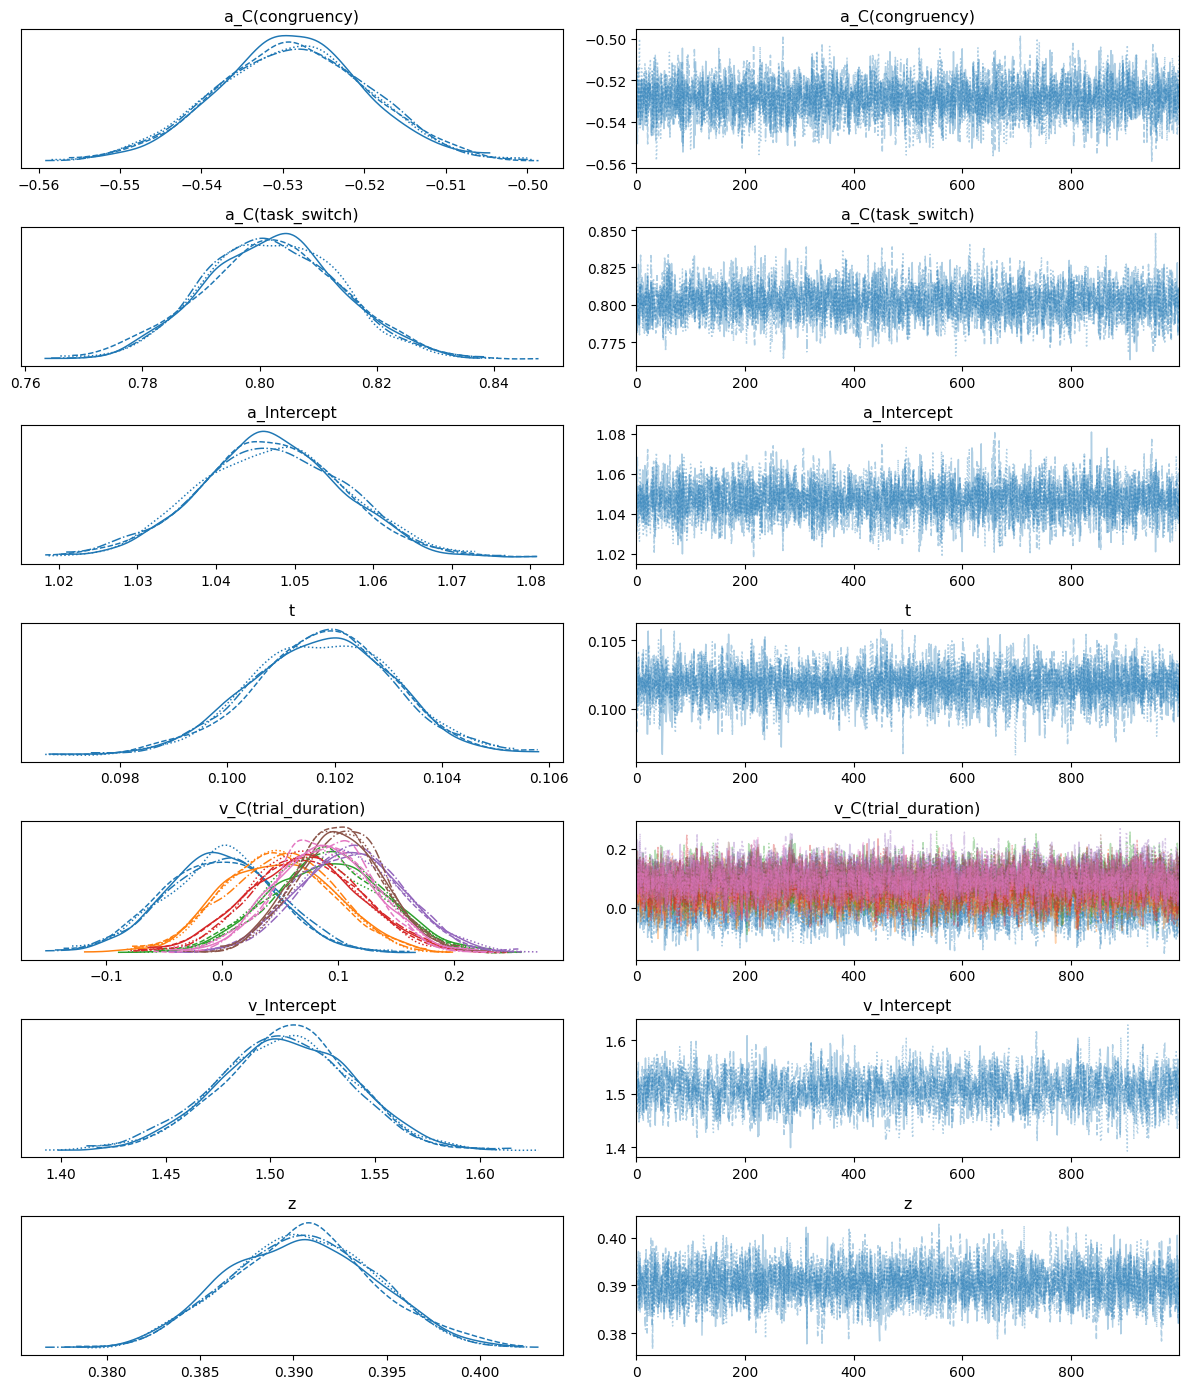

In [ ]:
az.plot_trace(reg_aCTS_vTD_sample, var_names=["~a", "~v"])
plt.tight_layout()

# Model Comparison



By following these steps below can systematically investigate the cognitive processes underlying task-switching and interference using the HDDM framework, ultimately identifying the model that best explains human decision-making behavior.

Model 4 shows the best fit to the experimental data, suggesting that incorporating trial duration effects on boundary separation and task-switching and congruency effects on drift rate provides the most comprehensive explanation of the decision-making process.




### Option 1: Load preprocessed data

We load the preprocessed data directly and start fitting models on it.

The preprocessing code can be found in a separate notebook [here](https://colab.research.google.com/drive/17ieZwioJCC3MrjM_FucLGMPU8ngy4uGm?usp=sharing).

Another option is to process the experimental data which is done in the next section.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/imtezcan/carneyModelingSuperExperimentHssm/main/data/switching_interference_preprocessed.csv')

### Option 2: Process Raw Data

In [ ]:
url = 'https://drive.google.com/drive/folders/196VuPGCjb4aS2b9vAsvT6FYoBYLuMJrY'
gdown.download_folder(url)
data_path = "/content/Data"
DATA_FILE = "switching_interference.csv"
df = pd.read_csv(data_path + '/' + DATA_FILE)

Retrieving folder contents


Processing file 1l2slSv6KrQNaKQLoi3jAfN0n9ODkZaZF interference.csv
Processing file 1sbISjw3OtBDo3up0OH7lgkdZmWNTDODi prp_and_single.csv
Processing file 1k_41HLZZCLv0BczM9foaam0uD8QOvuMr random.csv
Processing file 1kpyYvLkfmL8yh2nH5OBxbByi9xpfbxS1 switching_coherence.csv
Processing file 1Pq9yvFr9QSzMVcii0QSGpqp8p35Fdjxk switching_interference.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1l2slSv6KrQNaKQLoi3jAfN0n9ODkZaZF
To: /content/Data/interference.csv
100%|██████████| 17.1M/17.1M [00:00<00:00, 53.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sbISjw3OtBDo3up0OH7lgkdZmWNTDODi
To: /content/Data/prp_and_single.csv
100%|██████████| 21.4M/21.4M [00:00<00:00, 160MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k_41HLZZCLv0BczM9foaam0uD8QOvuMr
To: /content/Data/random.csv
100%|██████████| 31.7M/31.7M [00:00<00:00, 229MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kpyYvLkfmL8yh2nH5OBxbByi9xpfbxS1
To: /content/Data/switching_coherence.csv
100%|██████████| 37.6M/37.6M [00:00<00:00, 223MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pq9yvFr9QSzMVcii0QSGpqp8p35Fdjxk
To: /content/Data/switching_interference.csv
100%|██████████| 29.8M/29.8M [00:00<00:00, 220MB/s]
Download complet

Now we'll set a few constants related to the filtering of the data.

In [ ]:
ACCURACY_THRESHOLD = 0.7
MAX_NUMBER_OF_RESPONSES = 3

#### Basic Preprocessing for Modeling: Getting Response and Response Times

In [ ]:
def get_responses(key_presses):
  responses = [1 if key['correct'] else -1 for key in key_presses]
  if len(responses) < MAX_NUMBER_OF_RESPONSES:
    responses.extend([np.nan] * (MAX_NUMBER_OF_RESPONSES - len(responses)))
  return responses

def get_response_times(key_presses):
  response_times = [key['time'] for key in key_presses]
  if len(response_times) < MAX_NUMBER_OF_RESPONSES:
    response_times.extend([np.nan] * (MAX_NUMBER_OF_RESPONSES - len(response_times)))
  return response_times

def get_relative_response_times(row):
  key_presses = row["key_presses"]
  response_times = [key['time'] for key in key_presses]
  if len(response_times) < MAX_NUMBER_OF_RESPONSES:
    response_times.extend([np.nan] * (MAX_NUMBER_OF_RESPONSES - len(response_times)))
  return [x - row["go_1_start"] for x in response_times]

Now we'll interpret the `key_presses` column so that we can work with it. Then we'll extract responses and response times. Note that here we are getting up to `MAX_NUMBER_OF_RESPONSES` number of responses, but in the actual modeling we decided to use only the first response.

In [ ]:
if type(df.iloc[0]["key_presses"]) == str:
  df["key_presses"] = df["key_presses"].apply(eval) # this is necessary so that the functions can interpret the keypress data
responses_as_list = df['key_presses'].apply(get_responses)
response_times_as_list = df.apply(get_relative_response_times, axis=1)
for i in range(MAX_NUMBER_OF_RESPONSES):
  df[f'response_{i}'] = responses_as_list.apply(lambda x: x[i])
  df[f'response_time_{i}'] = response_times_as_list.apply(lambda x: x[i])

#### Slightly More Complex Preprocessing For Modeling: Add Column on Task, Orientation, and Movement Switches

How does the previous trial affect the current trial? We create features based on whether the task, the orientation, and the movement changed here.

In [ ]:
# Create a new column 'task_switch' which tells us if the current trial's task is different from the previous one's
df['task_switch'] = 1

# Did orientation and movement direction change?
df['or_switch'] = 1
df['mov_switch'] = 1

# Iterate over each block
for block, group in df.groupby(['subj_id', 'block']):
    df.loc[group.index[0], 'task_switch'] = 1
    df.loc[group.index[0], 'or_switch'] = 1
    df.loc[group.index[0], 'mov_switch'] = 1

    # Iterate over each timestep in the block
    for i in range(1, len(group)):

        current_task = group.iloc[i]['task_1']
        previous_task = group.iloc[i - 1]['task_1']

        current_or = group.iloc[i]['or_1_coherence']
        previous_or = group.iloc[i - 1]['or_1_coherence']

        current_mov = group.iloc[i]['mov_1_coherence']
        previous_mov = group.iloc[i - 1]['mov_1_coherence']

        # Set the value based on comparison
        if current_task == previous_task:
            df.loc[group.index[i], 'task_switch'] = 0
        else:
            df.loc[group.index[i], 'task_switch'] = 1

        if current_or == previous_or:
            df.loc[group.index[i], 'or_switch'] = 0
        else:
            df.loc[group.index[i], 'or_switch'] = 1

        if current_mov == previous_mov:
            df.loc[group.index[i], 'mov_switch'] = 0
        else:
            df.loc[group.index[i], 'mov_switch'] = 1

#### Adding Congruency
Are the triangles facing and moving in the same direction? This is an important feature about each trial which we like to adress here with modeling.

In [ ]:
df['congruency'] = (df['or_1_coherence'] * df['mov_1_coherence'] > 0).astype(float)

#### Filtering Options

We set a few flags for filtering. What we decided to filter out are:
* training trials
* data from participants who performed below 70% accuracy
* data from participants who submitted more than one response in any trial
* data from participants who did not respond at all in any trial
* some other options removing specific trials, which we actually end up not using to ensure for the same number of overall trials across participants

In [ ]:
REMOVE_TRIALS_IN_TRAINING = True #@param {type: "boolean"}
REMOVE_PARTICIPANTS_WITH_LOW_ACCURACY = True #@param {type: "boolean"}
REMOVE_TRIALS_WITH_MORE_THAN_MAX_RESPONSES = False #@param {type: "boolean"}
REMOVE_TRIALS_WITH_NO_RESPONSE = False #@param {type: "boolean"}
REMOVE_PARTICIPANTS_WITH_TOO_MANY_RESPONSES = True #@param {type:"boolean"}
REMOVE_PARTICIPANTS_WITH_NO_RESPONSE = True #@param {type:"boolean"}
REMOVE_PARTICIPANTS_WITH_ZERO_RT = True #@param {type:"boolean"}

In [ ]:
def filter_participants(df):
    valid_participants = []
    for participant_id, group in df.groupby('subj_id'):

        # Drop participants with more than 3 key presses in at least 1 trial
        if REMOVE_PARTICIPANTS_WITH_TOO_MANY_RESPONSES and (group['n_responses'] > 3).any():
            continue

        # Drop participants who has rt of 0 in any of the trials
        if REMOVE_PARTICIPANTS_WITH_ZERO_RT and (group['rt'] == 0).any():
            continue

        # Drop participants who has rt of nan in any of the trials
        if REMOVE_PARTICIPANTS_WITH_NO_RESPONSE and (group['rt'].isna()).any():
            continue

        valid_participants.append(participant_id)

    return df[df['subj_id'].isin(valid_participants)]

In [ ]:
print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants before filtering.")

if REMOVE_TRIALS_IN_TRAINING:
  df = df[~df['block'].str.startswith('train')]
  print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering out training trials.")

if REMOVE_PARTICIPANTS_WITH_TOO_MANY_RESPONSES or REMOVE_PARTICIPANTS_WITH_ZERO_RT:
  print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering participants zero RT and too many responses.")

if REMOVE_PARTICIPANTS_WITH_LOW_ACCURACY:
  trials_count = len(df[df['subj_id'] == df['subj_id'].iloc[0]])
  for participant in df['subj_id'].unique():
    accuracy_count = len(df.loc[(df['subj_id'] == participant) & (df['response_0'] == 1.0), 'response_0'])
    if accuracy_count/trials_count < ACCURACY_THRESHOLD:
      df = df.drop(df[df['subj_id'] == participant].index)
  print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering out low accuracy participants.")

if REMOVE_TRIALS_WITH_MORE_THAN_MAX_RESPONSES:
  df = df[df['key_presses'].apply(len) <= MAX_NUMBER_OF_RESPONSES]
  print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering out high response trials.")

if REMOVE_TRIALS_WITH_NO_RESPONSE:
  df = df[df['key_presses'].apply(len) > 0]
  print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering no response trials.")

df['n_responses'] = df['key_presses'].apply(len)  # For convenience
df['rt'] = df['response_time_0']/1000  # Needed for HSSM
df['response'] = df['response_0']  # Needed for HSSM
df = filter_participants(df)  # Drop participants, if enabled
print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering participants with too many responses, no response or 0 RT.")

75810 number of trials and 172 participants before filtering.
53840 number of trials and 172 participants after filtering out training trials.
53840 number of trials and 172 participants after filtering participants zero RT and too many responses.
37680 number of trials and 118 participants after filtering out low accuracy participants.
13680 number of trials and 43 participants after filtering participants with too many responses, no response or 0 RT.


#### Paring down the number of columns in the dataset

We'll get rid of irrelevant columns from the dataset such as the ones corresponding to a second task that a participant could do during a single trial, rename some columns for the purposes of using the hssm toolbox, and change all columns with some time information from milliseconds to seconds.

In [ ]:
df = df.loc[:, ["response_time_0", "response_0", "cue_1_dur", "congruency", "task_switch"]]
df = df.rename(columns={"response_time_0": "rt", "response_0": "response", "cue_1_dur" : "trial_duration"})
df["rt"] = df["rt"] / 1000
df["trial_duration"] = df["trial_duration"] / 1000
df.head()

rt  response  trial_duration  congruency  task_switch
1865  0.886909       1.0            2.97         1.0            1
1866  1.172032       1.0            2.97         1.0            1
1867  1.612332       1.0            2.97         0.0            0
1868  1.497332       1.0            2.97         1.0            0
1869  0.923555       1.0            2.97         0.0            1

## Data Visualization

#### Error Rates by Task Transition
In this plot, the percentage of wrong responses with respect to task transition status is represented.

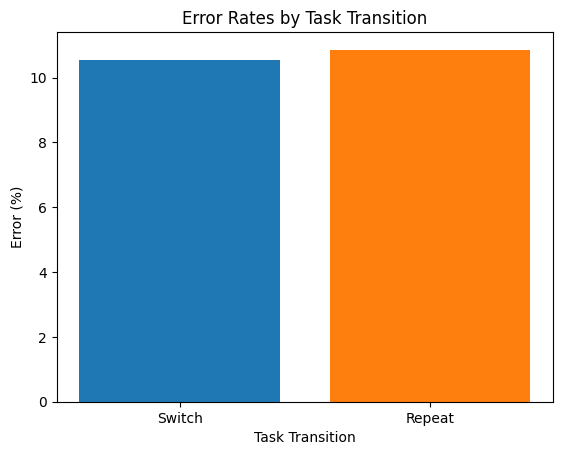

In [ ]:
df_switch = len(df['task_switch'][df['task_switch']==1])
df_repeat = len(df['task_switch'][df['task_switch']==0])

error_switch = len(df[df['response']==-1])
error_repeat = len(df[df['response']==-1])

error_rate_switch = (error_switch / df_switch) * 100
error_rate_repeat = (error_repeat / df_repeat) * 100

fig, ax = plt.subplots()

bar1 = ax.bar('Switch', error_rate_switch)
bar2 = ax.bar('Repeat', error_rate_repeat)

ax.set_xlabel('Task Transition')
ax.set_ylabel('Error (%)')
ax.set_title('Error Rates by Task Transition')


plt.show()

#### Error Rates by Trial Duration
In this plot, the percentage of wrong responses with respect to trial duration is represented.

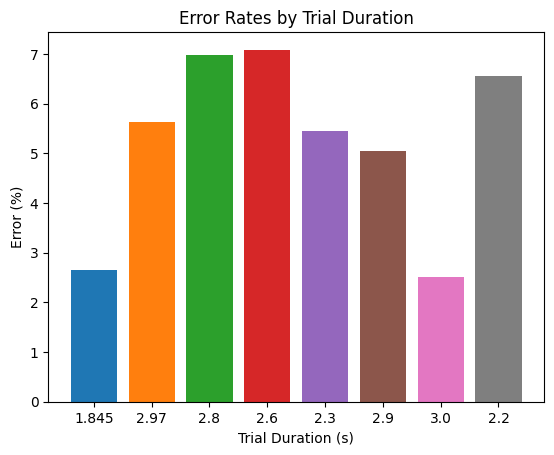

In [ ]:
for duration in list(set(df['trial_duration'])):
  error = len(df[(df['response']==-1.0) & (df['trial_duration']==duration)]['response'])
  error_rate = (error / len(df[df['trial_duration']==duration]) * 100)
  plt.bar(f'{duration}', error_rate)
plt.xlabel('Trial Duration (s)')
plt.ylabel('Error (%)')
plt.title('Error Rates by Trial Duration')
plt.show()

#### Distribution of Trial Durations vs Response Times
In this plot, the distribution of trial durations vs response times is represented.

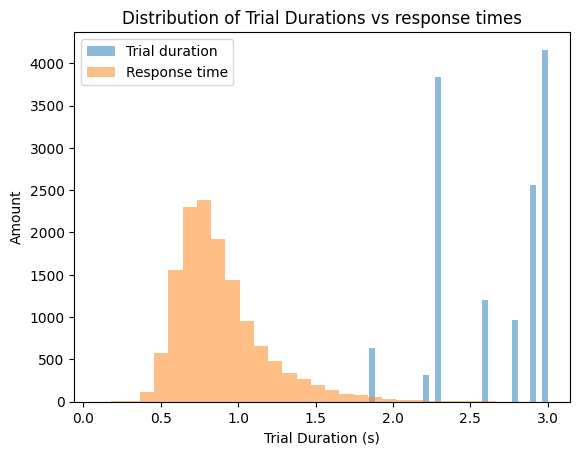

In [ ]:
plt.hist(df['trial_duration'], bins=30,alpha=0.5,label='Trial Duration')
plt.hist(df['rt'], bins=30,alpha=0.5, label='Response Time')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Amount')
plt.title('Distribution of Trial Durations vs Response Times')
plt.legend()
plt.show()

#### Distribution of Reaction Times by Task Switchv
In this plot, the distribution of reaction times by task_switch is represented.

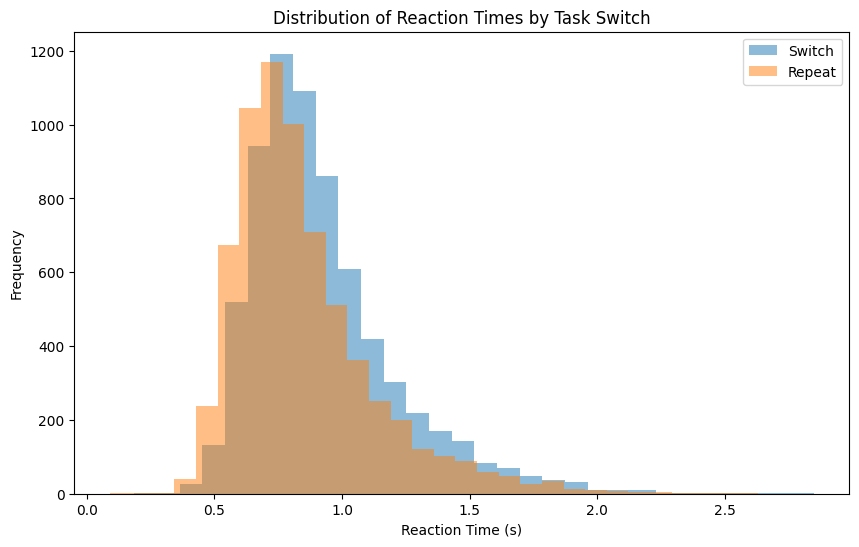

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['rt'][df['task_switch']== 1], bins=30, alpha=0.5, label='Switch')
plt.hist(df['rt'][df['task_switch']== 0], bins=30, alpha=0.5, label='Repeat')
plt.xlabel('Reaction Time (s)')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times by Task Switch')
plt.legend()

#### Distribution of Reaction Times by Congruency
In this plot, the distributions of reaction times for two cases of congruent and incongruent trials are represented.

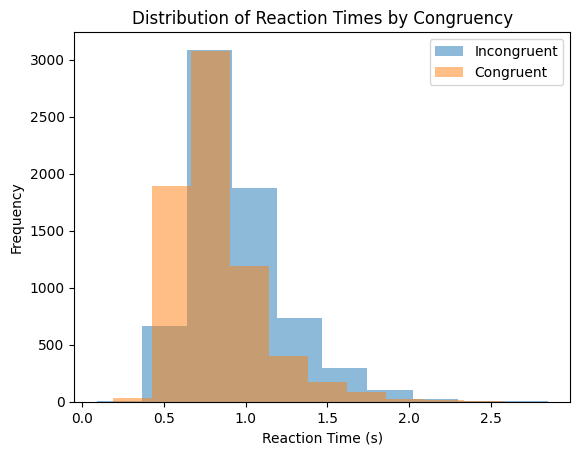

In [ ]:
plt.hist(df[df['congruency'] == 0]['rt'], alpha=0.5, label='Incongruent')
plt.hist(df[df['congruency'] == 1]['rt'], alpha=0.5, label='Congruent')
plt.xlabel('Reaction Time (s)')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times by Congruency')
plt.legend()

# Model Fitting
The provided code sets up and fits five different Drift Diffusion Models (DDMs) using hierarchical Bayesian methods. Each model incorporates different combinations of predictors (congruency, task_switch, trial_duration) on various DDM parameters (drift rate v and boundary separation a). The models are implemented using the hssm package.


Simulated Data:

*   Generate synthetic data using predefined parameter values for each model.
*   Fit each model to the simulated data to assess if the original parameters can be accurately recovered.
*   Quantitative evaluation involves comparing the estimated parameters to the original ones used for simulation.

Real Data:

*   Preprocess the experimental data (e.g., filtering outliers, normalizing, etc.).
*   Fit all models to the real data.
*   Plot the behavior of the best-fitting model against the actual experimental data to visualize how well it explains human decision-making.



    
    


In [ ]:
models = dict()
simple_ddm = hssm.HSSM(data=df[["response", "rt"]])
models["simple_ddm"] = simple_ddm

regression_v = hssm.HSSM(
    data=df[["response", "rt", "congruency", "task_switch"]],
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 2.0
                }
            },
            "formula": "v ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        }
    ]
)
models["regression_v"] = regression_v

regression_a = hssm.HSSM(
    data=df[["rt", "response", "congruency", "task_switch"]],
    include=[
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "a ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        }
    ]
)
models["regression_a"] = regression_a

regression_vCTS_aTD = hssm.HSSM(
    data=df,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 2.0
                }
            },
            "formula": "v ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "a ~ 1 + C(trial_duration)",
            "link": "identity",
        }
    ]
)
models["regression_vCTS_aTD"] = regression_vCTS_aTD

reg_aCTS_vTD = hssm.HSSM(
    data=df[["response", "rt", "congruency", "task_switch", "trial_duration"]],
    include=[
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "a ~ 1 + C(congruency) + C(task_switch)",
            "link": "identity",
        },
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 2.0
                }
            },
            "formula": "v ~ 1 + C(trial_duration)",
            "link": "identity",
        }
    ]
)



#### Set up some constants for all future sampling

NUM_CHAINS : Running multiple chains helps ensure that the sampler explores the posterior distribution thoroughly, reducing the risk of being stuck in local minima and improving convergence diagnostics.

NUM_CORES: Utilizing multiple cores speeds up the computation by running chains simultaneously, which is particularly useful for large models or datasets.

NUM_DRAWS: A larger number of draws ensures a more accurate and stable estimation of the posterior distribution. It reduces the Monte Carlo error and provides a more precise estimate of the parameters.

NUM_TUNE: Tuning iterations allow the sampler to adapt to the target distribution, adjusting parameters like step size and proposal distribution to improve sampling efficiency and convergence.


In [ ]:
NUM_CHAINS = 4 #the number of Markov chains to be run in parallel during the sampling process.
NUM_CORES = 4 #the number of CPU cores to be used for parallel processing.
NUM_DRAWS = 4000 #the number of posterior samples to draw after the tuning period.
NUM_TUNE = 1000 #the number of tuning (or "warm-up") iterations to perform before the actual sampling starts.

#### Model 1: Sampling for simple DDM

In [ ]:
basic_ddm_model_sample = simple_ddm.sample(
    sampler="nuts_numpyro",
    cores=NUM_CORES,
    chains=NUM_CHAINS,
    draws=NUM_DRAWS,
    tune=NUM_TUNE,
    idata_kwargs=dict(log_likelihood=False)
)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 5000/5000 [01:48<00:00, 46.28it/s, 8 steps of size 9.17e-02. acc. prob=0.84]
ERROR:pymc.stats.convergence:There were 13158 divergences after tuning. Increase `target_accept` or reparameterize.


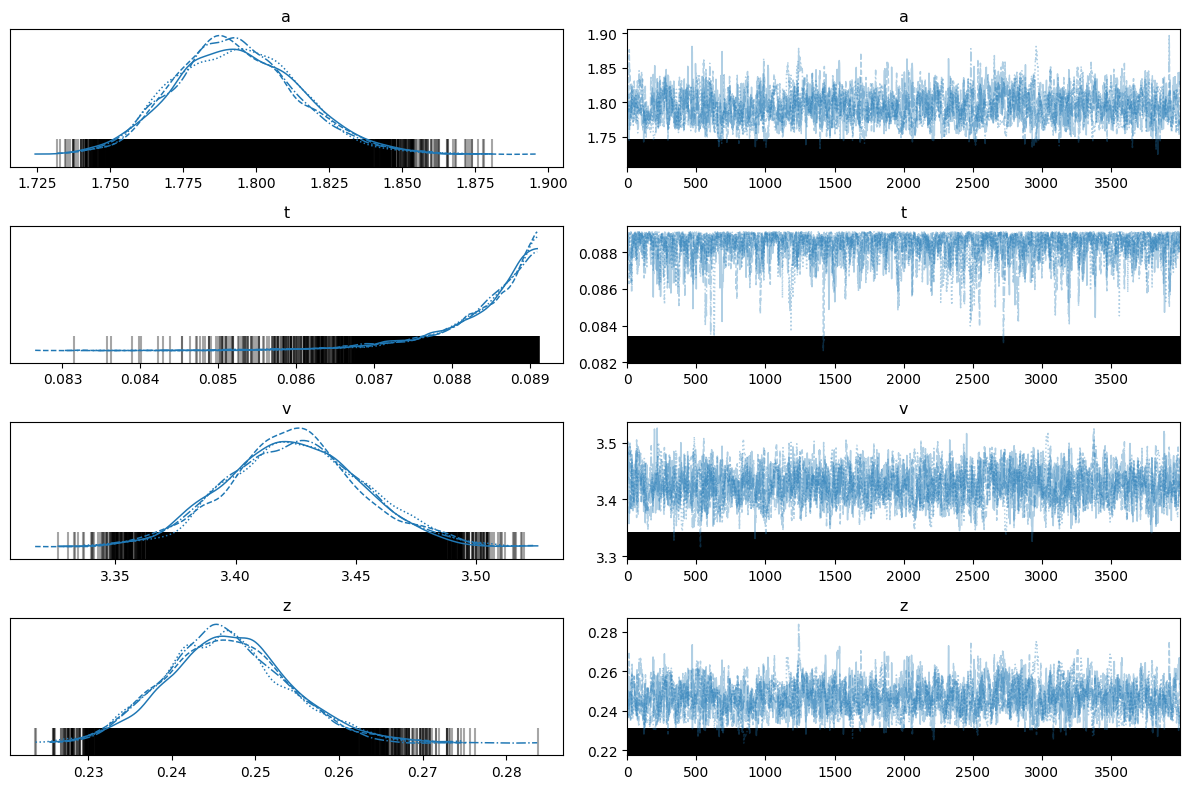

In [ ]:
az.plot_trace(basic_ddm_model_sample)
plt.tight_layout()

In [ ]:
az.summary(basic_ddm_model_sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  1.793  0.021   1.754    1.832      0.001    0.001     643.0    1286.0   
t  0.088  0.001   0.087    0.089      0.000    0.000    1155.0    1814.0   
v  3.425  0.028   3.372    3.478      0.001    0.001     979.0    1835.0   
z  0.247  0.007   0.233    0.261      0.000    0.000     643.0    1342.0   

   r_hat  
a    1.0  
t    1.0  
v    1.0  
z    1.0

Key Columns in the Output


*   mean: The mean of the posterior distribution of the parameter.
*   sd: The standard deviation of the posterior distribution, indicating the uncertainty around the mean estimate.
*   hdi_3% and hdi_97%: The 3% and 97% highest density intervals (HDI) of the parameter, representing the 94% credible interval.
*   mcse_mean and mcse_sd: The Monte Carlo standard errors for the mean and standard deviation, respectively, indicating the error due to the finite number of samples.
*  ess_bulk and ess_tail: The effective sample size for the bulk and tail of the posterior distribution, respectively, indicating how well the samples represent the posterior.
*  r_hat: The potential scale reduction factor, a convergence diagnostic. Values close to 1.00 indicate good convergence.



#### Model 2: Sampling for DDM with regression on drift rate

In [ ]:
model_reg_v_sample = model_reg_v.sample(
    sampler="nuts_numpyro",
    cores=NUM_CORES,
    chains=NUM_CHAINS,
    draws=NUM_DRAWS,
    tune=NUM_TUNES,
    idata_kwargs=dict(log_likelihood=True)
)

Compiling.. :   0%|          | 0/5000 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/5000 [00:03<?, ?it/s]


Running chain 0:   5%|▌         | 250/5000 [07:04<2:13:11,  1.68s/it]





Running chain 0:  10%|█         | 500/5000 [15:07<2:17:08,  1.83s/it]



Running chain 0:  15%|█▌        | 750/5000 [19:13<1:42:13,  1.44s/it]


Running chain 0:  20%|██        | 1000/5000 [22:55<1:21:36,  1.22s/it]


Running chain 0:  25%|██▌       | 1250/5000 [26:13<1:06:44,  1.07s/it]


Running chain 0:  30%|███       | 1500/5000 [29:00<54:22,  1.07it/s]  





Running chain 0:  35%|███▌      | 1750/5000 [32:13<47:39,  1.14it/s]


Running chain 0:  40%|████      | 2000/5000 [35:10<41:17,  1.21it/s]


Running chain 0:  45%|████▌     | 2250/5000 [38:40<38:02,  1.20it/s]


Running chain 0:  50%|█████     | 2500/5000 [41:41<33:13,  1.25it/s]


Running chain 0:  55%|█████▌    | 2750/5000 [44:18<27:55,  1.34it/s]


Running chain 0:  60%|██████    | 3000/5000 [46:49<23:24,  1.42it/s]


Running c

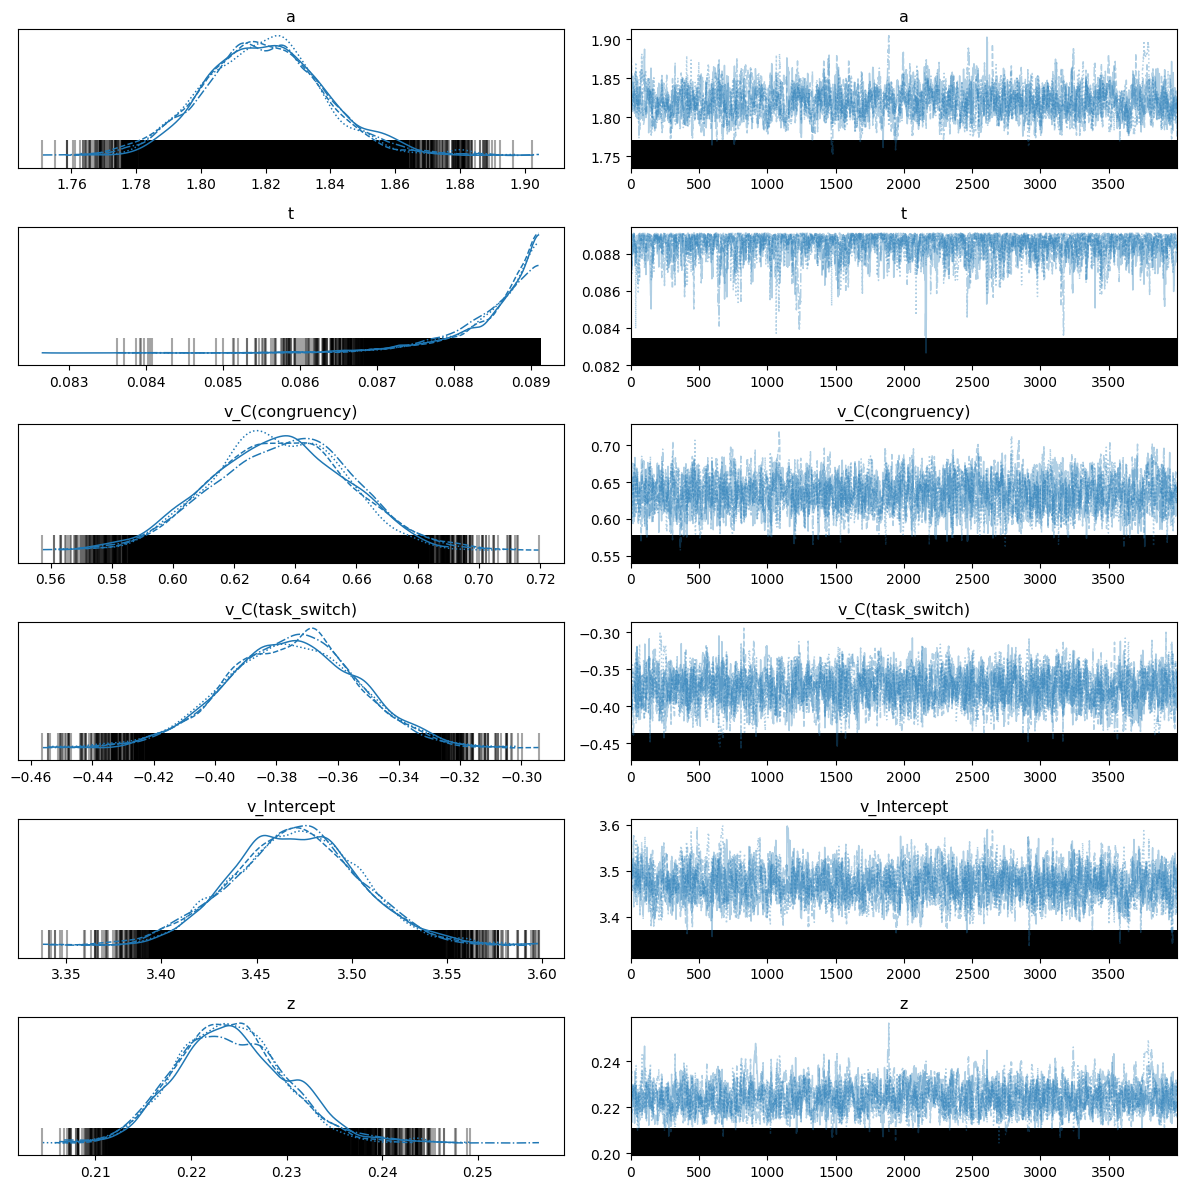

In [ ]:
az.plot_trace(model_reg_v_sample, var_names=["~v"])
plt.tight_layout()

In [ ]:
az.summary(model_reg_v_sample, var_names=["~v"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                    1.820  0.018   1.786    1.854      0.001    0.000   
t                    0.088  0.001   0.087    0.089      0.000    0.000   
v_C(congruency)[1]   0.635  0.022   0.593    0.675      0.001    0.000   
v_C(task_switch)[1] -0.375  0.021  -0.413   -0.333      0.001    0.000   
v_Intercept          3.471  0.034   3.407    3.533      0.001    0.001   
z                    0.224  0.006   0.214    0.235      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
a                       856.0    1218.0   1.00  
t                      1124.0    2055.0   1.00  
v_C(congruency)[1]     1151.0    1715.0   1.01  
v_C(task_switch)[1]    1331.0    1698.0   1.00  
v_Intercept            1125.0    2150.0   1.00  
z                      1092.0    1643.0   1.00

#### Model 3: Sampling for DDM with regression on boundary separation

In [ ]:
regression_a_sample = regression_a.sample(
    sampler="nuts_numpyro",
    cores=NUM_CORES,
    chains=NUM_CHAINS,
    draws=NUM_DRAWS,
    tune=NUM_TUNES,
    idata_kwargs=dict(log_likelihood=True)
)

Compiling.. :   0%|          | 0/5000 [00:00<?, ?it/s]







Running chain 0:   5%|▌         | 250/5000 [03:49<1:11:21,  1.11it/s]


Running chain 0:  10%|█         | 500/5000 [07:18<1:04:37,  1.16it/s]


Running chain 0:  20%|██        | 1000/5000 [14:25<56:12,  1.19it/s] 

Running chain 0:  25%|██▌       | 1250/5000 [18:30<55:49,  1.12it/s]

Running chain 0:  30%|███       | 1500/5000 [22:47<54:44,  1.07it/s]


Running chain 0:  35%|███▌      | 1750/5000 [26:14<48:53,  1.11it/s]

Running chain 0:  45%|████▌     | 2250/5000 [31:49<35:53,  1.28it/s]

Running chain 0:  50%|█████     | 2500/5000 [36:10<36:00,  1.16it/s]


Running chain 0:  55%|█████▌    | 2750/5000 [40:25<34:10,  1.10it/s]

Running chain 0:  60%|██████    | 3000/5000 [44:16<30:29,  1.09it/s]

Running chain 0:  65%|██████▌   | 3250/5000 [47:13<24:51,  1.17it/s]

Running chain 0:  75%|███████▌  | 3750/5000 [54:05<17:34,  1.18it/s]


Running chain 0:  80%|████████  | 4000/5000 [58:03<14:37,  1.14it/s]

Running chain 0:  85

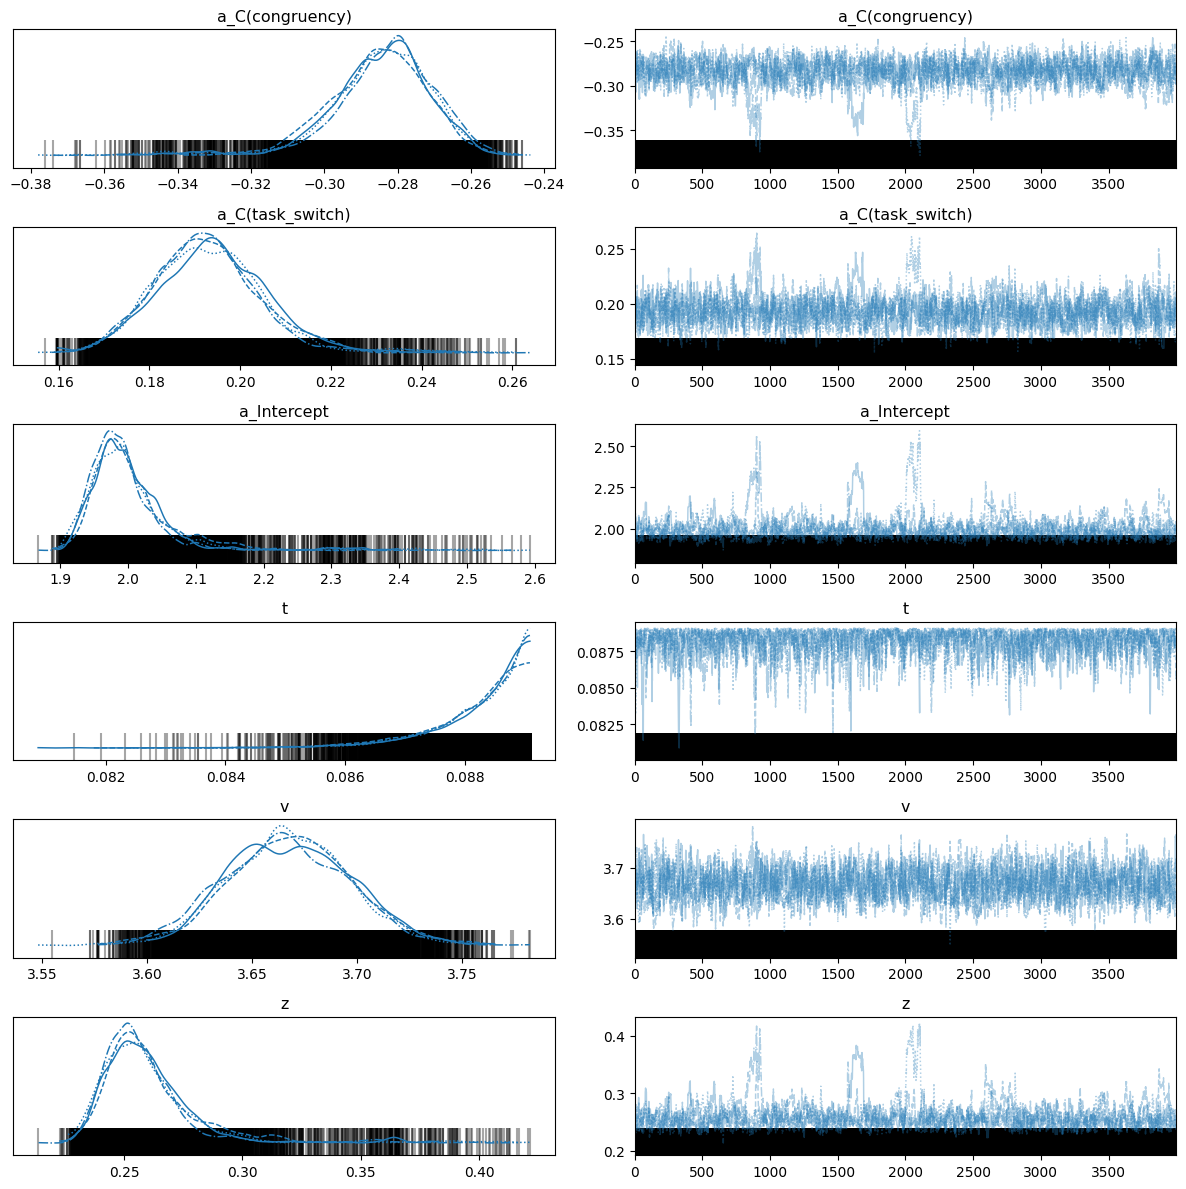

In [ ]:
az.plot_trace(regression_a_sample, var_names=["~a"])
plt.tight_layout()

In [ ]:
az.summary(regression_a_sample, var_names=["~a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_C(congruency)[1]  -0.284  0.014  -0.309   -0.260      0.001    0.001   
a_C(task_switch)[1]  0.193  0.012   0.171    0.216      0.001    0.000   
a_Intercept          2.001  0.068   1.911    2.104      0.005    0.004   
t                    0.088  0.001   0.087    0.089      0.000    0.000   
v                    3.668  0.029   3.616    3.724      0.001    0.001   
z                    0.260  0.022   0.230    0.294      0.002    0.001   

                     ess_bulk  ess_tail  r_hat  
a_C(congruency)[1]      435.0     363.0   1.01  
a_C(task_switch)[1]     415.0     375.0   1.02  
a_Intercept             303.0     236.0   1.02  
t                      1187.0    2660.0   1.00  
v                       842.0    1910.0   1.00  
z                       337.0     249.0   1.02

#### Model 4: Sampling for DDM with regression on drift rate v (task_switch and congruency) and boundary separation a (trial_duration)

In [ ]:
regression_vCTS_aTD_model_sample = regression_vCTS_aTD.sample(
    sampler="nuts_numpyro",
    cores=NUM_CORES,
    chains=NUM_CHAINS,
    draws=NUM_DRAWS,
    tune=NUM_TUNE,
    idata_kwargs=dict(log_likelihood=True)
)

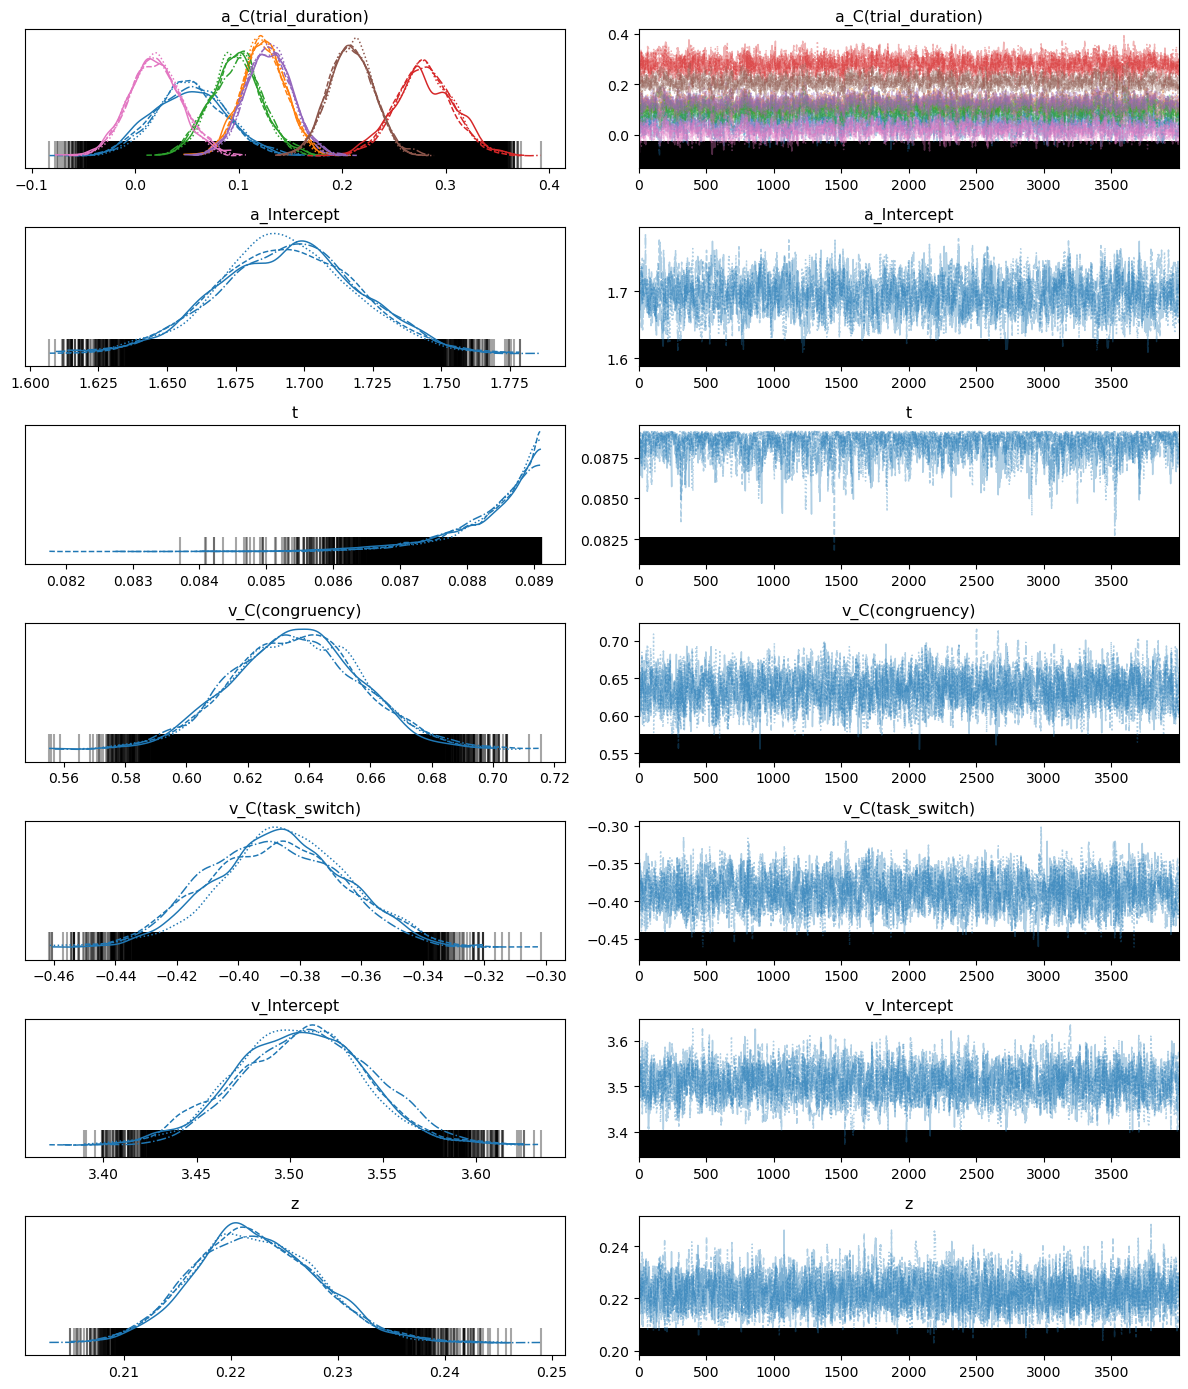

In [ ]:
az.plot_trace(regression_vCTS_aTD_model_sample, var_names=["~a", "~v"])
plt.tight_layout()

In [ ]:
az.summary(regression_vCTS_aTD_model_sample, var_names=["~a", "~v"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_C(trial_duration)[2.2]   0.053  0.034  -0.011    0.116      0.001    0.001   
a_C(trial_duration)[2.3]   0.124  0.021   0.084    0.163      0.001    0.001   
a_C(trial_duration)[2.6]   0.098  0.025   0.050    0.143      0.001    0.001   
a_C(trial_duration)[2.8]   0.280  0.028   0.227    0.334      0.001    0.001   
a_C(trial_duration)[2.9]   0.129  0.022   0.090    0.174      0.001    0.001   
a_C(trial_duration)[2.97]  0.209  0.021   0.170    0.250      0.001    0.001   
a_C(trial_duration)[3.0]   0.019  0.025  -0.029    0.066      0.001    0.001   
a_Intercept                1.694  0.025   1.648    1.744      0.001    0.001   
t                          0.088  0.001   0.087    0.089      0.000    0.000   
v_C(congruency)[1.0]       0.636  0.021   0.596    0.675      0.001    0.000   
v_C(task_switch)[1]       -0.387  0.021  -0.425   -0.345      0.001    0.000   
v_Intercept                3.506  0.034   3.445    3.573      0.001    0.001   
z                          0.222  0.006   0.212    0.233      0.000    0.000   

                           ess_bulk  ess_tail  r_hat  
a_C(trial_duration)[2.2]      889.0    1685.0   1.01  
a_C(trial_duration)[2.3]      659.0    1164.0   1.00  
a_C(trial_duration)[2.6]      681.0    1071.0   1.00  
a_C(trial_duration)[2.8]      890.0    1312.0   1.00  
a_C(trial_duration)[2.9]      680.0    1241.0   1.00  
a_C(trial_duration)[2.97]     666.0    1311.0   1.00  
a_C(trial_duration)[3.0]      711.0    1114.0   1.00  
a_Intercept                   780.0    1344.0   1.00  
t                             939.0    2087.0   1.00  
v_C(congruency)[1.0]         1487.0    2188.0   1.01  
v_C(task_switch)[1]          1120.0    2020.0   1.01  
v_Intercept                  1260.0    1452.0   1.01  
z                            1916.0    2704.0   1.00

#### Model 5: Sampling with regression on drift rate v (trial_duration) and boundary separation a (task_switch and congruency)

In [ ]:
regression_vTD_aCTS_sample = regression_vTD_aCTS.sample(
    sampler="nuts_numpyro",
    cores=NUM_CORES,
    chains=NUM_CHAINS,
    draws=NUM_DRAWS,
    tune=NUM_TUNE,
    idata_kwargs=dict(log_likelihood=True)
)

Compiling.. :   0%|          | 0/5000 [00:00<?, ?it/s]







Running chain 0:   5%|▌         | 250/5000 [04:14<1:19:14,  1.00s/it]


Running chain 0:  15%|█▌        | 750/5000 [10:37<57:56,  1.22it/s]  

Running chain 0:  20%|██        | 1000/5000 [14:05<54:55,  1.21it/s]

Running chain 0:  25%|██▌       | 1250/5000 [18:28<56:39,  1.10it/s]


Running chain 0:  45%|████▌     | 2250/5000 [34:44<44:33,  1.03it/s]


Running chain 0:  75%|███████▌  | 3750/5000 [1:04:02<22:46,  1.09s/it]


Running chain 0: 100%|██████████| 5000/5000 [1:22:50<00:00,  1.04it/s]

































Running chain 3: 100%|██████████| 5000/5000 [2:51:52<00:00,  2.06s/it]
There were 14237 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is n

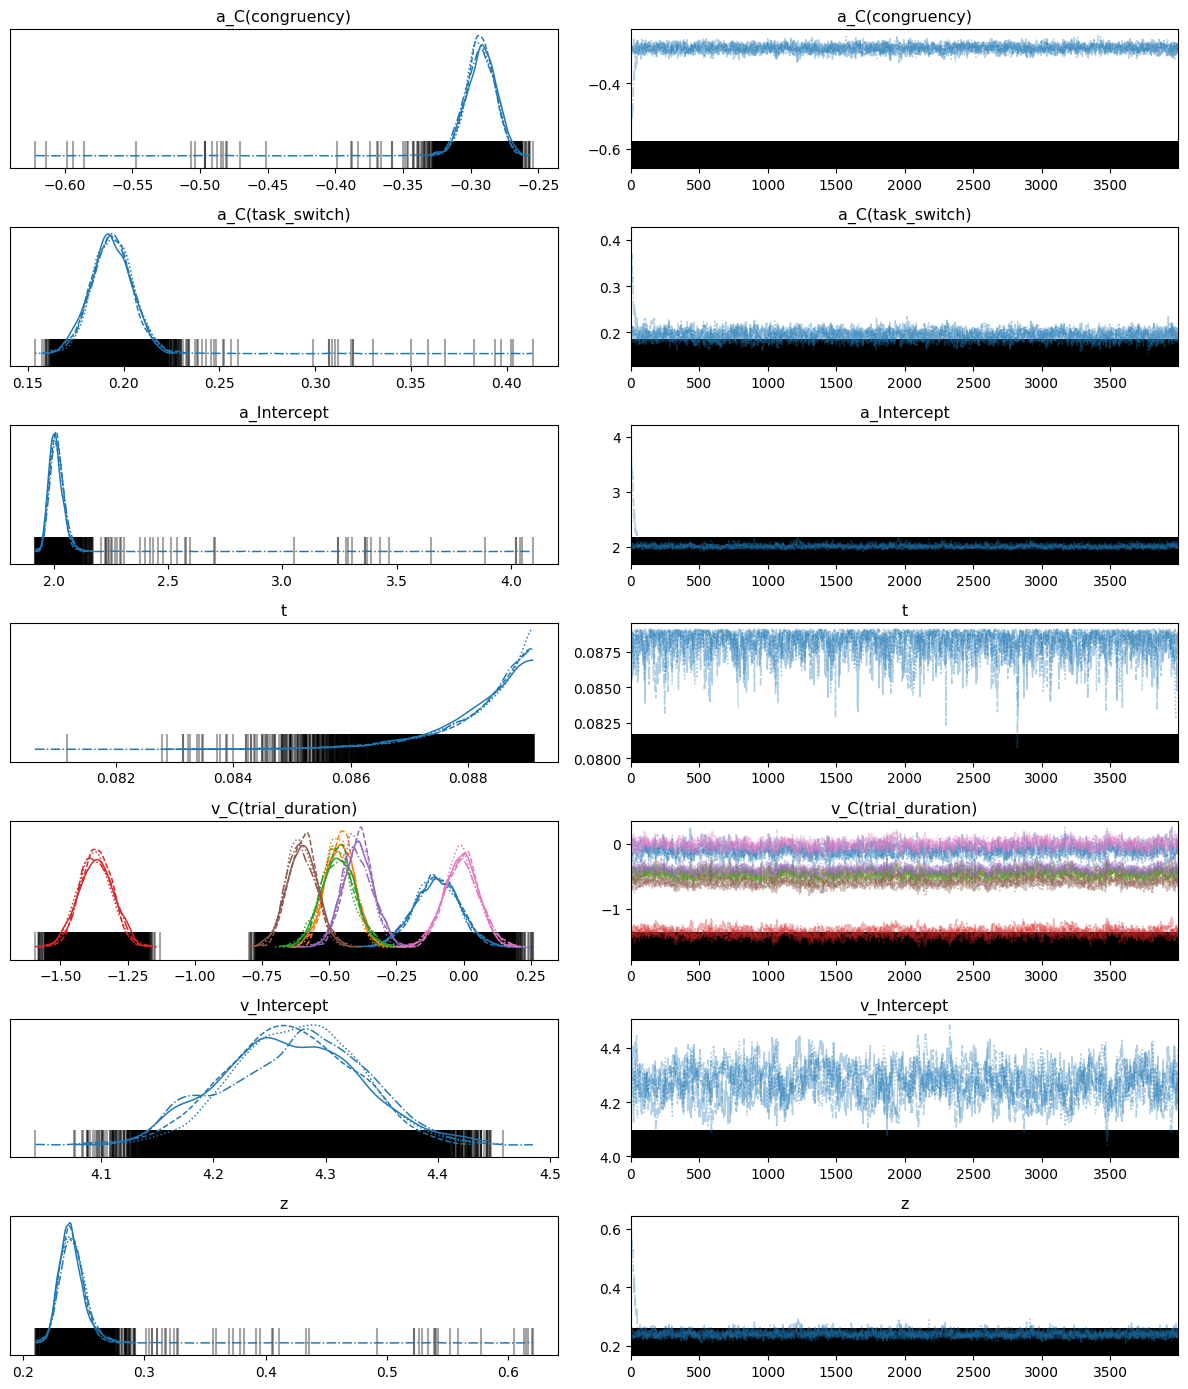

In [ ]:
az.plot_trace(regression_vTD_aCTS_sample, var_names=["~v", "~a"])
plt.tight_layout()

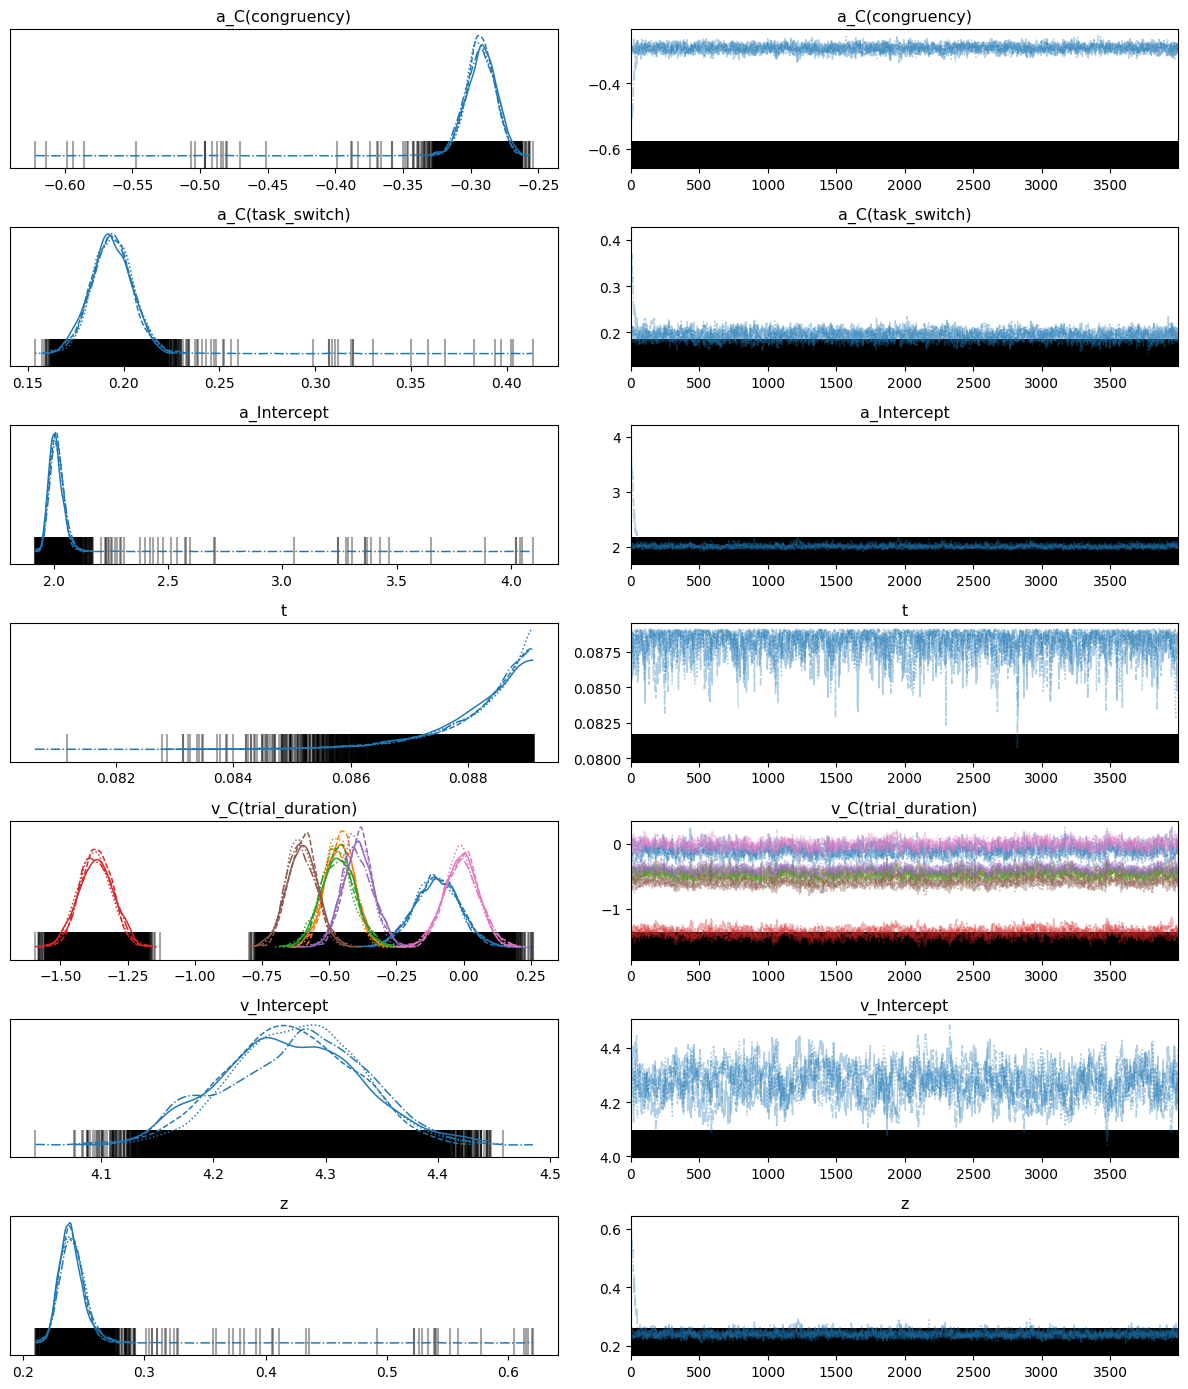

In [ ]:
az.plot_trace(regression_vTD_aCTS_sample, var_names=["~v", "~a"])
plt.tight_layout()

# Comparison of the five models
The output from the model comparison provides several insights into the performance and robustness of the different DDM models.
We'll download the traces for all five models and then run them through Arviz's compare function.

In [ ]:
traces_drive_folder = "https://drive.google.com/drive/folders/1OQCPLtC-QaCBANsWx0T-VZfrkahLzTvj"
gdown.download_folder(traces_drive_folder)

In [ ]:
traces_folder = "/content/Inference Data/"
basic_ddm_model_sample = az.from_netcdf(traces_folder + "basic_ddm_model_sample.nc")
model_reg_v_sample = az.from_netcdf(traces_folder + "model_reg_v_sample.nc")
regression_a_sample = az.from_netcdf(traces_folder + "regression_a_sample.nc")
regression_vCTS_aTD_model_sample = az.from_netcdf(traces_folder + "regression_vCTS_aTD_model_sample.nc")
regression_vTD_aCTS_sample = az.from_netcdf(traces_folder + "Pelin_regression_vTD_aCTS_sample.nc")
compare_data = az.compare(compare_dict={"Basic DDM":basic_ddm_model_sample,
                         "DDM with Regression on v" : model_reg_v_sample,
                         "DDM with Regression on a" : regression_a_sample,
                         "DDM with v dependent on task switch and a dependent on trial duration": regression_vCTS_aTD_model_sample,
                         "DDM with a dependent on task switch and v dependent on trial duration": regression_vTD_aCTS_sample})
compare_data

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1023: RuntimeWarning: invalid value encountered in divide
  len_scale = n * (np.log(-(b_ary / k_ary)) - k_ary - 1)
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1039: RuntimeWarning: invalid value encountered in scalar divide
  sigma = -k_post / b_post
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and L

rank     elpd_loo  \
DDM with a dependent on task switch and v depen...     0 -3448.524106   
DDM with v dependent on task switch and a depen...     1 -3736.633193   
DDM with Regression on v                               2 -3856.303046   
DDM with Regression on a                               3 -3868.171451   
Basic DDM                                              4          NaN   

                                                        p_loo   elpd_diff  \
DDM with a dependent on task switch and v depen...  11.823204    0.000000   
DDM with v dependent on task switch and a depen...  12.157500  288.109087   
DDM with Regression on v                             5.071466  407.778940   
DDM with Regression on a                             4.531183  419.647346   
Basic DDM                                                 NaN         NaN   

                                                    weight          se  \
DDM with a dependent on task switch and v depen...     0.2  172.198014   
DDM with v dependent on task switch and a depen...     0.2  169.673810   
DDM with Regression on v                               0.2  169.974587   
DDM with Regression on a                               0.2  172.772005   
Basic DDM                                              0.2         NaN   

                                                          dse  warning scale  
DDM with a dependent on task switch and v depen...   0.000000     True   log  
DDM with v dependent on task switch and a depen...  30.541160     True   log  
DDM with Regression on v                            41.361688     True   log  
DDM with Regression on a                            38.781982     True   log  
Basic DDM                                                 NaN     True   log

The model with a dependent on task switch and v dependent on trial duration is the best-performing model based on ELPD. However, all models have warnings indicating potential robustness issues.

 * Rank 0: This is the best-performing model.
 * elpd_loo: -3448.52 (highest ELPD, indicating the best fit).
 * p_loo: 11.82 (moderate complexity).
 * weight: 0.2 (equal probability assigned to all models due to identical weights).
 * warning: True (indicates potential issues with model robustness).

## Simulating from the winning model and compare it to the empirical data

In [ ]:
# Plotting RT histograms

def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):


  # set up figure
  fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)  # 1 row, 2 columns

  # Plot the histograms for upper threshold
  axs[0].hist(rt_upper_simulated, bins=30, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[0].hist(rt_upper_empirical, bins=30, alpha=0.5, color='orange', label='Experimental Data')
  axs[0].set_xlabel('Reaction Time (s)')
  axs[0].set_ylabel('Counts')
  axs[0].legend()
  #axs[0].set_ylim([0, y_max])
  axs[0].set_title('Correct Responses')

  # Plot the histograms for lower threshold
  axs[1].hist(rt_lower_simulated, bins=30, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[1].hist(rt_lower_empirical, bins=30, alpha=0.5, color='orange', label='Experimental Data')
  axs[1].set_xlabel('Reaction Time (s)')
  axs[1].set_ylabel('Counts')
  axs[1].legend()
  #axs[1].set_ylim([0, y_max])
  axs[1].set_title('Incorrect Responses')

  # Adjust layout
  plt.tight_layout()

  # Display the figure
  plt.show()

In [ ]:
# Run summary from the winning model

winning_model_sum = az.summary(regression_vCTS_aTD_model_sample, var_names=["~v", "~a"])
print(winning_model_sum)

recovered_parameters = regression_vCTS_aTD_model_sample.posterior.stack(draws=("chain", "draw")).mean()
recovered_parameters_as_dict = {}
for param, param_dict in recovered_parameters.to_dict()["data_vars"].items():
    recovered_parameters_as_dict [param] = param_dict["data"]

# Run the simulation from the winning model - Extract the parameters to be the 'mean' from the summary
# Check how it's simulated above

sim_winning_model = hssm.simulate_data(model='ddm', theta=recovered_parameters_as_dict, size=df.shape[0])

                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_C(trial_duration)[2.2]   0.053  0.034  -0.011    0.116      0.001    0.001   
a_C(trial_duration)[2.3]   0.124  0.021   0.084    0.163      0.001    0.001   
a_C(trial_duration)[2.6]   0.098  0.025   0.050    0.143      0.001    0.001   
a_C(trial_duration)[2.8]   0.280  0.028   0.227    0.334      0.001    0.001   
a_C(trial_duration)[2.9]   0.129  0.022   0.090    0.174      0.001    0.001   
a_C(trial_duration)[2.97]  0.209  0.021   0.170    0.250      0.001    0.001   
a_C(trial_duration)[3.0]   0.019  0.025  -0.029    0.066      0.001    0.001   
a_Intercept                1.694  0.025   1.648    1.744      0.001    0.001   
t                          0.088  0.001   0.087    0.089      0.000    0.000   
v_C(congruency)[1.0]       0.636  0.021   0.596    0.675      0.001    0.000   
v_C(task_switch)[1]       -0.387  0.021  -0.425   -0.345      0.001    0.000   
v_Intercept                3.506  0.034 

## Interpretation of the winning model based on the values above

* in the best model, the boundary separation (a) is dependent on the trial duration.
* a_Intercept: The baseline value for boundary separation is 1.694, which is relatively high. This indicates that, in general, the decision-making process requires a substantial amount of information, suggesting a bias towards accuracy over speed.

* Shorter trial durations (e.g., 2.2 seconds) have a smaller impact on boundary separation (0.053).
As trial duration increases, the effect on boundary separation becomes more pronounced (e.g., 0.280 for 2.8 seconds).
* For the longest trial durations (e.g., 3.0 seconds), the effect is minimal (0.019), indicating that boundary separation is primarily influenced by the intercept rather than trial duration at these levels.

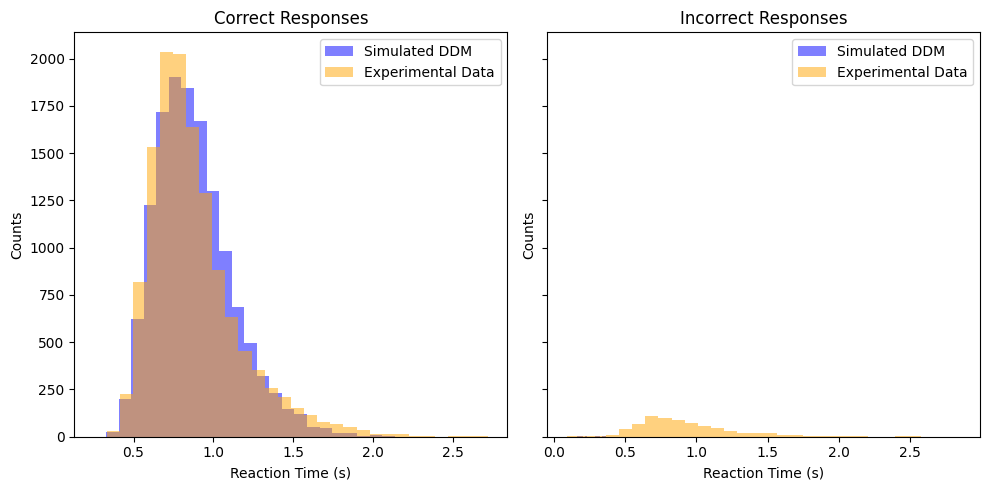

In [ ]:
rt_sim_cor = sim_winning_model[sim_winning_model['response']==1.0]['rt']
rt_sim_err = sim_winning_model[sim_winning_model['response']==-1.0]['rt']

rt_exp_cor = df[df['response']==1.0]['rt']
rt_exp_err = df[df['response']==-1.0]['rt']

plot_ddm_histograms(rt_sim_cor, rt_sim_err, rt_exp_cor, rt_exp_err)

In the end, the best model among the five models is the model which correlates the drift rate with task switching and congruency, and the boundary separation with the trial duration.  The elpd_loo value for the basic DDM could not be determined so it is unclear how the other four models compare to it if we treat it as a baseline.

We find in the simulation of the best model that it does a decent job at matching the distribution of correct responses with that of the experimental data. However, it does not make any incorrect responses, whereas the experimental data show a small number of incorrect responses which concentrate around the 700 millisecond mark. The best model and other candidate models estimate a high drift rate, over 3 (specifically 3.506 for the best model), which could explain why the model never chooses an incorrect response.

We see that the v_C(task_switch) parameter does negatively impact the drift rate, which is expected as the subject would be under higher cognitive load to perform the task switch. Also, congruency between movement and orientation has a positive effect on drift rate, which is also not surprising.